# **Seller Churn Model**

## **1. Seller Data Cleaning**

### **1.1 Import Libraries and Dataset**

In [1]:
# import library
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import missingno as ms
from scipy import stats

# train test split
from sklearn.model_selection import train_test_split

# impute missing values
from sklearn.impute import SimpleImputer # mean, median, most_frequent (mode), constant
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer # regresi
from sklearn.impute import KNNImputer # regresi KKN

# encoding
from sklearn.preprocessing import OneHotEncoder
from category_encoders import OrdinalEncoder, BinaryEncoder

# scaling
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler 

# column transformer & pipeline
from sklearn.compose import ColumnTransformer
#from sklearn.pipeline import Pipeline

# evaluation metrics
from sklearn.metrics import precision_score, make_scorer, ConfusionMatrixDisplay, roc_auc_score, average_precision_score, confusion_matrix

# cross validation
from sklearn.model_selection import cross_val_score

# algorithm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from mlxtend.evaluate import GroupTimeSeriesSplit

#Resampling
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.pipeline import Pipeline

# Ensemble Various Type
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Ensemble Similar Type
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier      # Bagging
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier # Boosting
from xgboost import XGBClassifier
import xgboost

# metric
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, make_scorer

# hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Polynomial feature
from sklearn.preprocessing import PolynomialFeatures

# ensemble
from sklearn.ensemble import VotingClassifier, StackingClassifier, VotingRegressor

pd.set_option('display.max_columns', 100)

In [2]:
base_dir = "D:\\Purwadhika\\Finpro\\Dataset\\"

seller_df = pd.read_csv(base_dir + "seller_data.csv")

In [3]:
seller_df.head()

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01 00:00:00,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30 00:00:00,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20 00:00:00,campinas,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04 00:00:00,mogi-guacu,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03 00:00:00,mogi-guacu,SP


### **1.2 Exploratory Data Analysis**

In [4]:
listItem = []
for col in seller_df.columns :
    listItem.append([col, seller_df[col].dtype, seller_df[col].isna().sum(), round((seller_df[col].isna().sum()/len(seller_df[col])) * 100,2),
                    seller_df[col].nunique(), list(seller_df[col].drop_duplicates().sample(2).values)]);

seller_dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
seller_dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,seller_id,object,0,0.00,3095,"[0432ead42b6c8a0bdf68154add917fdf, 365e445f796..."
1,seller_zip_code_prefix,int64,0,0.00,2246,"[86076, 28660]"
2,seller_city,object,0,0.00,611,"[mombuca, brasilia df]"
3,seller_state,object,0,0.00,23,"[SC, RN]"
4,order_id,object,0,0.00,98666,"[d5d69378d9ce32d540e8474e6423b5b5, 2ef4a11b6e2..."
5,order_item_id,int64,0,0.00,21,"[17, 20]"
6,product_id,object,0,0.00,32951,"[073ed404e3aec5b0a486334c05ee2fe9, fde0eff5653..."
7,shipping_limit_date,object,0,0.00,93318,"[2018-08-01 16:25:27, 2018-05-09 21:10:27]"
8,price,float64,0,0.00,5968,"[519.0, 25.33]"
9,freight_value,float64,0,0.00,6999,"[16.8, 70.14]"


<Axes: >

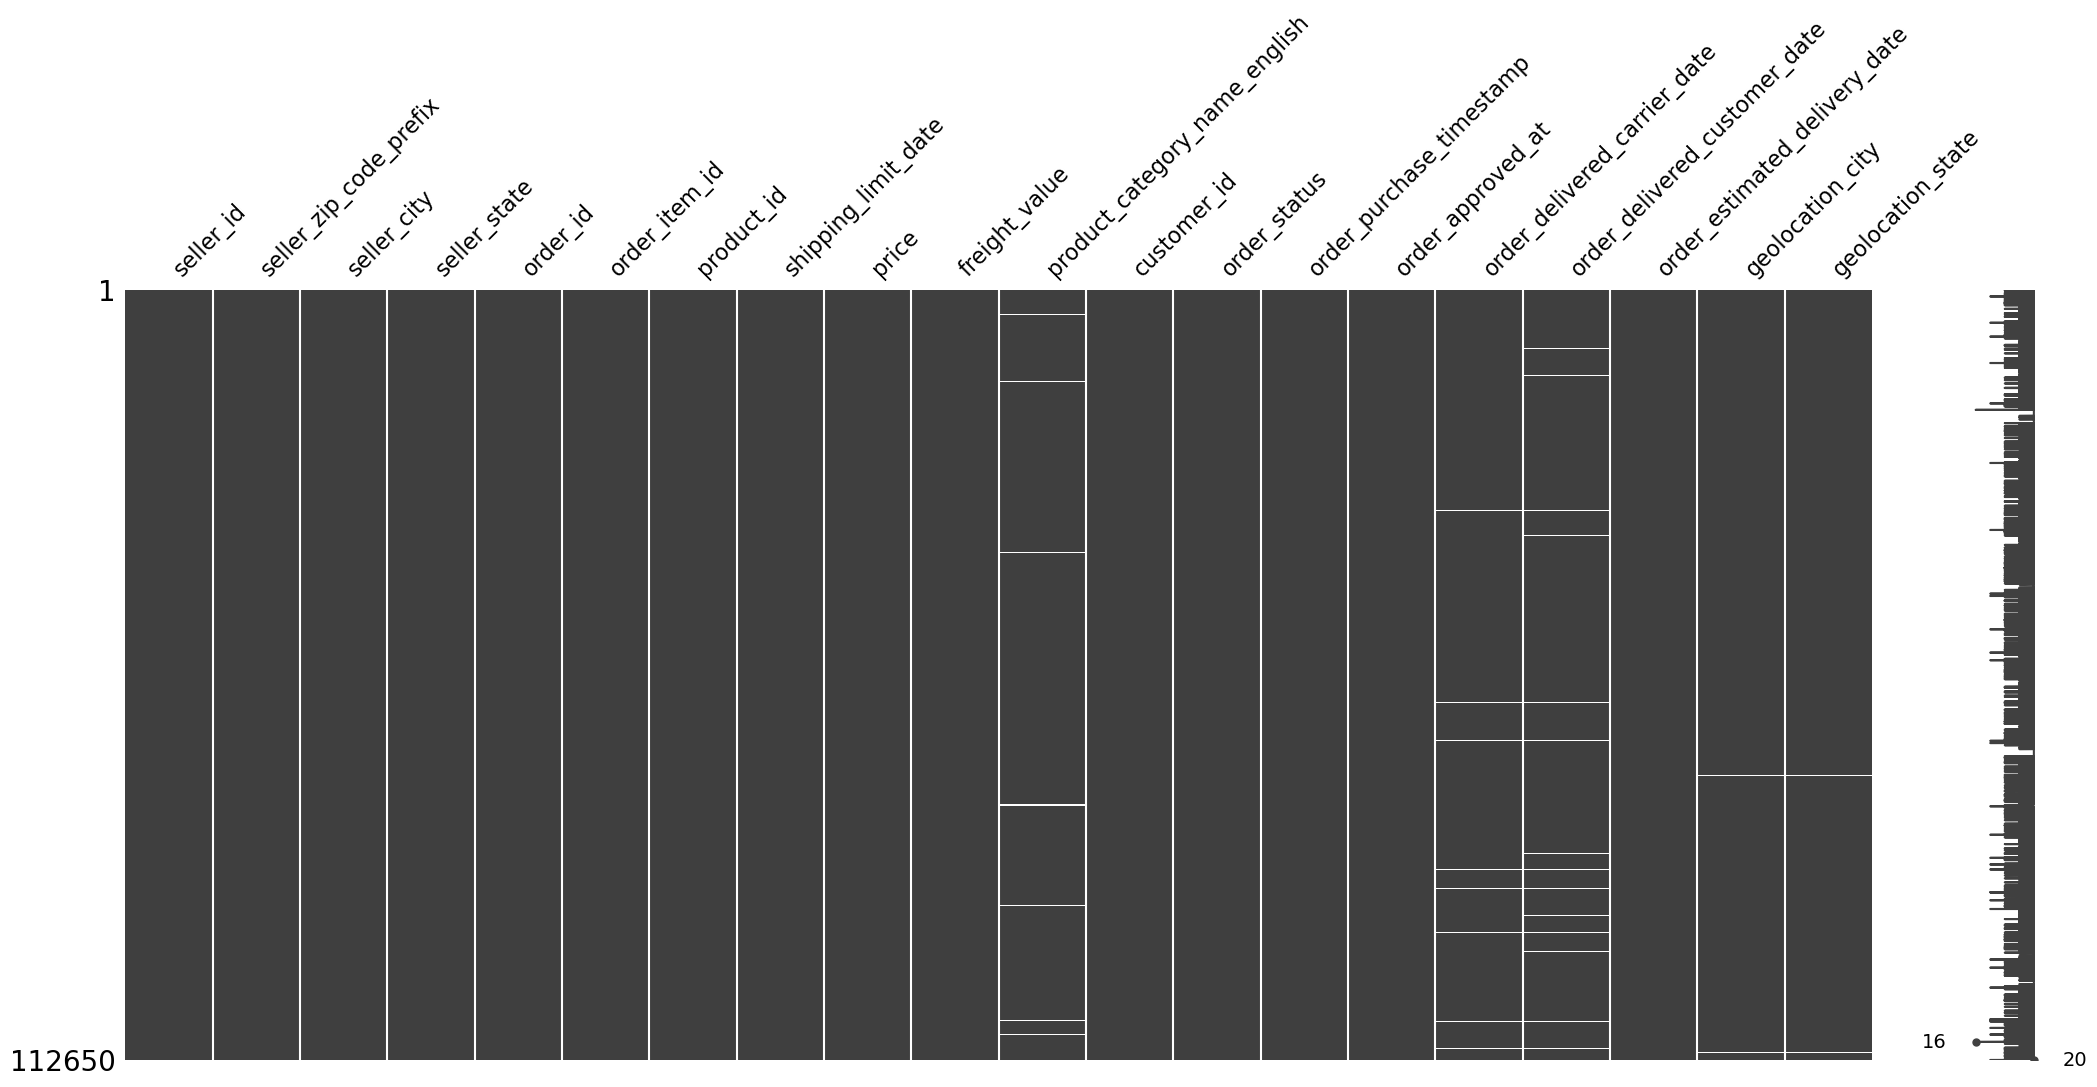

In [5]:
ms.matrix(seller_df)

In [6]:
# from skrub import TableReport
# report = TableReport(seller_df)
# report

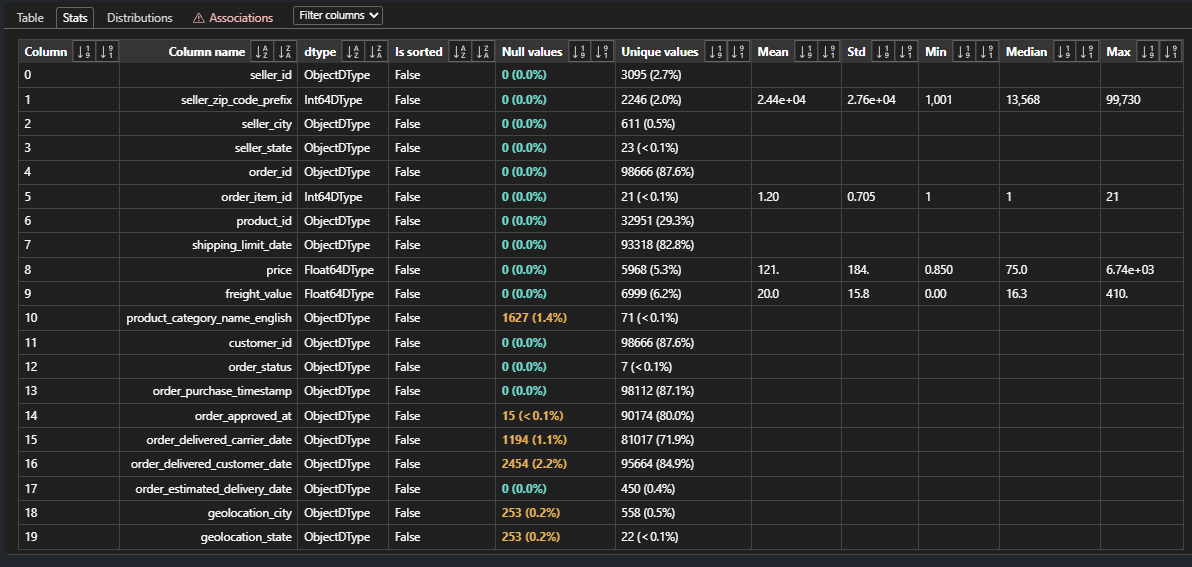
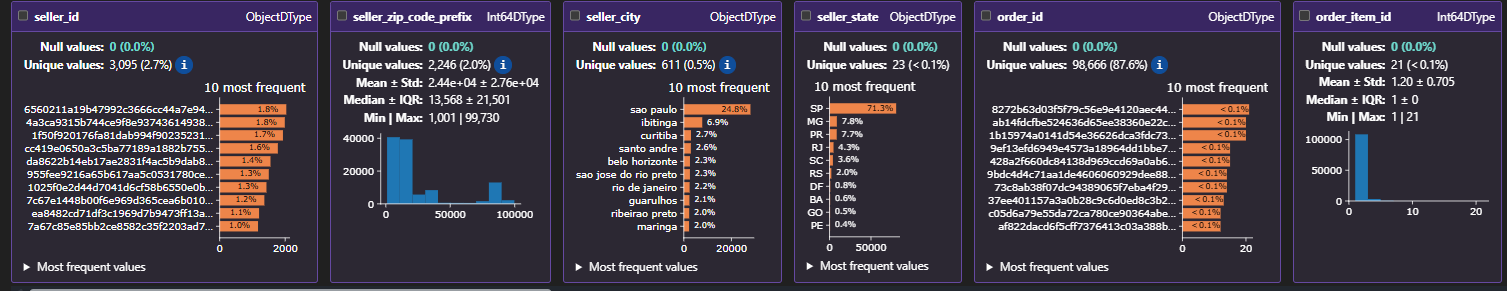
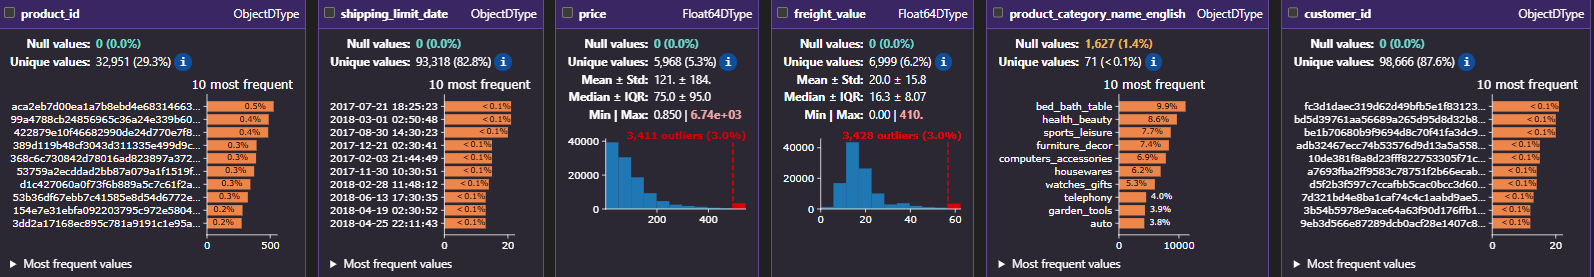
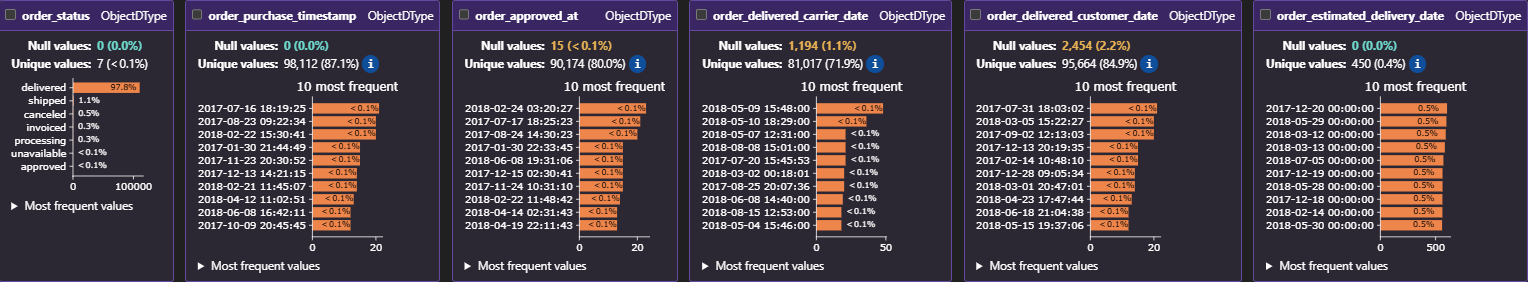
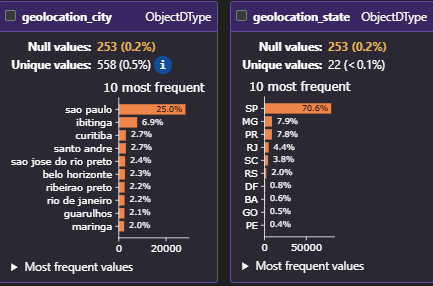
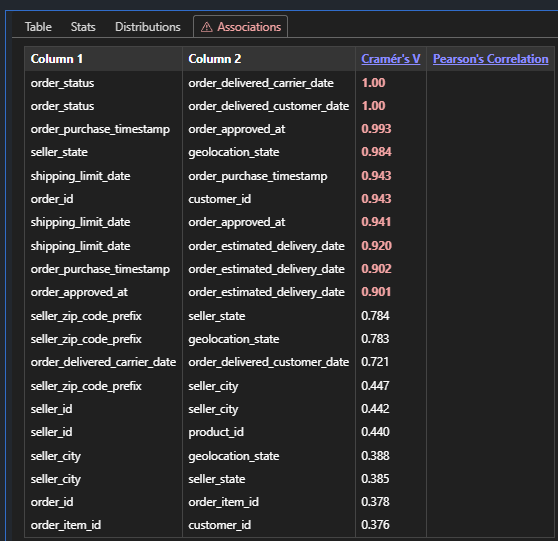

### **1.3 Changing Data Type**

For the convinience of analysis, all of the data related to date will be converted from object into timedate data type

In [7]:
seller_df['shipping_limit_date'] = pd.to_datetime(seller_df['shipping_limit_date'], format= '%Y-%m-%d %H:%M:%S')
seller_df['order_purchase_timestamp'] = pd.to_datetime(seller_df['order_purchase_timestamp'], format= '%Y-%m-%d %H:%M:%S')
seller_df['order_approved_at'] = pd.to_datetime(seller_df['order_approved_at'], format= '%Y-%m-%d %H:%M:%S')
seller_df['order_delivered_carrier_date'] = pd.to_datetime(seller_df['order_delivered_carrier_date'], format= '%Y-%m-%d %H:%M:%S')
seller_df['order_delivered_customer_date'] = pd.to_datetime(seller_df['order_delivered_customer_date'], format= '%Y-%m-%d %H:%M:%S')
seller_df['order_estimated_delivery_date'] = pd.to_datetime(seller_df['order_estimated_delivery_date'], format= '%Y-%m-%d %H:%M:%S')

In [8]:
seller_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 20 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   seller_id                      112650 non-null  object        
 1   seller_zip_code_prefix         112650 non-null  int64         
 2   seller_city                    112650 non-null  object        
 3   seller_state                   112650 non-null  object        
 4   order_id                       112650 non-null  object        
 5   order_item_id                  112650 non-null  int64         
 6   product_id                     112650 non-null  object        
 7   shipping_limit_date            112650 non-null  datetime64[ns]
 8   price                          112650 non-null  float64       
 9   freight_value                  112650 non-null  float64       
 10  product_category_name_english  111023 non-null  object        
 11  

### **1.4. Missing Data Handling**

#### **1.4.1 product_category_name_english**

In [9]:
seller_df[seller_df["product_category_name_english"].isna()]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
374,166e8f1381e09651983c38b1f6f91c11,88780,imbituba,SC,346222690118b5713fed10ff0c262bda,1,fb34a3bfc66ae09f045f9613fdb7bb5c,2017-08-01 02:25:15,39.9,15.10,NaN,c297e17b11dce86ab05956099fd565df,delivered,2017-07-25 01:53:48,2017-07-26 02:25:15,2017-07-31 19:24:49,2017-08-07 22:03:57,2017-08-16,imbituba,SC
375,166e8f1381e09651983c38b1f6f91c11,88780,imbituba,SC,f1ba1af891ddd14899ba97155589732f,1,fb34a3bfc66ae09f045f9613fdb7bb5c,2017-08-25 00:44:36,38.9,15.10,NaN,c55f7aac91e0605d8f8333211949bd5e,delivered,2017-08-21 00:27:44,2017-08-21 00:44:36,2017-08-25 18:45:50,2017-09-05 15:15:37,2017-09-13,imbituba,SC
455,f7496d659ca9fdaf323c0aae84176632,4156,sao paulo,SP,780865d48893bd12dd23eb85abed0c6e,1,c7858457bc43561ccb96aaa2932cb085,2017-11-17 19:26:35,279.9,28.40,NaN,c2d0429940ce0afef52e564623133aec,delivered,2017-10-26 19:14:49,2017-10-26 19:26:35,2017-10-31 11:54:54,2017-11-01 18:42:13,2017-11-24,sao paulo,SP
460,f7496d659ca9fdaf323c0aae84176632,4156,sao paulo,SP,b27a97d99c7b7966d9860555f748ec70,1,c7858457bc43561ccb96aaa2932cb085,2017-06-12 16:42:56,279.9,54.34,NaN,d12e078e5f950d108069a5a368fd98a0,delivered,2017-05-23 16:25:28,2017-05-23 16:42:56,2017-05-26 08:05:07,2017-06-01 18:04:28,2017-06-23,sao paulo,SP
461,f7496d659ca9fdaf323c0aae84176632,4156,sao paulo,SP,c2320c404179d2b8805c42b8b8de9668,2,c7858457bc43561ccb96aaa2932cb085,2018-07-11 20:31:41,289.9,43.57,NaN,6b9961cd2c203b4154482e717236a58e,delivered,2018-07-04 19:19:21,2018-07-05 16:22:03,2018-07-05 15:53:00,2018-07-11 18:07:42,2018-08-01,sao paulo,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112644,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,683076b91bcaf79259334f6aa80d41a3,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-13 11:32:53,27.0,16.05,NaN,58cd1c5b5fc40c1bc3448b6bae54f34b,delivered,2017-02-07 11:32:53,2017-02-09 02:43:17,2017-02-10 07:07:57,2017-02-13 11:09:14,2017-03-10,pelotas,RS
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.0,16.05,NaN,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,pelotas,RS
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.0,10.96,NaN,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,pelotas,RS
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.0,16.05,NaN,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,pelotas,RS


Since we don't know exactly what is the product from the product_id, therefor we impute the missing datas with a new category called "unknown"

In [10]:
seller_df["product_category_name_english"] = seller_df["product_category_name_english"].fillna("unknown")

In [11]:
seller_df["product_category_name_english"].isna().sum()

np.int64(0)

#### **1.4.2 order_approved_at**

In [12]:
seller_df[seller_df["order_approved_at"].isna()]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
3186,4e7c18b98d84e05cbae3ff0ff03846c2,14882,jaboticabal,SP,e04abd8149ef81b95221e88f6ed9ab6a,1,0e20a07ca1714df21f9b07ca3bf7c682,2017-02-22 13:40:00,309.90,39.11,small_appliances,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18 14:40:00,NaT,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17,jaboticabal,SP
6318,5fd924b4836098a5be0ecf81ba054ce0,3554,sao paulo,SP,2eecb0d85f281280f79fa00f9cec1a95,1,4fd676d9c4723d475026e40aeae56957,2017-02-21 16:21:55,135.00,19.23,garden_tools,a3d3c38e58b9d2dfb9207cab690b6310,delivered,2017-02-17 17:21:55,NaT,2017-02-22 11:42:51,2017-03-03 12:16:03,2017-03-20,sao paulo,SP
12412,004c9cd9d87a3c30c522c48c4fc07416,14940,ibitinga,SP,3c0b8706b065f9919d0505d3b3343881,1,db8ed3d08891d16a2438a67ab3acb740,2017-02-22 14:53:27,133.99,23.20,bed_bath_table,d85919cb3c0529589c6fa617f5f43281,delivered,2017-02-17 15:53:27,NaT,2017-02-22 11:31:30,2017-03-03 11:47:47,2017-03-23,ibitinga,SP
56575,3481aa57cd91f9f9d3fa1fa12d9a3bf7,13360,capivari,SP,7013bcfc1c97fe719a7b5e05e61c12db,1,583916a5dae918f5e89baec139141c54,2017-02-22 12:29:47,49.99,15.53,unknown,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18 13:29:47,NaT,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17,capivari,SP
73208,a4b6b9b992b46e9ef863637af96e04bc,88090,florianopolis,SC,8a9adc69528e1001fc68dd0aaebbb54a,1,2c2b6a28924791234bd386bddb17512e,2017-02-22 11:45:31,379.00,17.86,construction_tools_safety,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18 12:45:31,NaT,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21,florianopolis,SC
77210,cca3071e3e9bb7d12640c9fbe2301306,14940,ibitinga,SP,51eb2eebd5d76a24625b31c33dd41449,1,7868a64aa111bbb4f41f8e1146c0becb,2017-02-28 14:52:27,59.90,17.16,furniture_decor,07a2a7e0f63fd8cb757ed77d4245623c,delivered,2017-02-18 15:52:27,NaT,2017-02-23 03:09:14,2017-03-07 13:57:47,2017-03-29,ibitinga,SP
77294,cca3071e3e9bb7d12640c9fbe2301306,14940,ibitinga,SP,7002a78c79c519ac54022d4f8a65e6e8,1,c3b271f47e73d0c9ccf1b43b7606c705,2017-01-29 22:26:59,45.90,14.52,furniture_decor,d5de688c321096d15508faae67a27051,delivered,2017-01-19 22:26:59,NaT,2017-01-27 11:08:05,2017-02-06 14:22:19,2017-03-16,ibitinga,SP
77647,cca3071e3e9bb7d12640c9fbe2301306,14940,ibitinga,SP,d69e5d356402adc8cf17e08b5033acfb,1,cae2e38942c8489d9d7a87a3f525c06b,2017-02-26 01:28:47,149.80,13.63,furniture_decor,68d081753ad4fe22fc4d410a9eb1ca01,delivered,2017-02-19 01:28:47,NaT,2017-02-23 03:11:48,2017-03-02 03:41:58,2017-03-27,ibitinga,SP
80497,7a67c85e85bb2ce8582c35f2203ad736,3426,sao paulo,SP,12a95a3c06dbaec84bcfb0e2da5d228a,1,c6dd917a0be2a704582055949915ab32,2017-02-21 12:05:55,79.99,15.77,cool_stuff,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17 13:05:55,NaT,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20,sao paulo,SP
80601,7a67c85e85bb2ce8582c35f2203ad736,3426,sao paulo,SP,2babbb4b15e6d2dfe95e2de765c97bce,1,c6dd917a0be2a704582055949915ab32,2017-02-22 16:15:03,79.99,26.82,cool_stuff,74bebaf46603f9340e3b50c6b086f992,delivered,2017-02-18 17:15:03,NaT,2017-02-22 11:23:11,2017-03-03 18:43:43,2017-03-31,sao paulo,SP


In [13]:
seller_df[seller_df["order_approved_at"].isna()]["order_status"].unique()

array(['delivered'], dtype=object)

All of the `order_status` data that have missing values at `order_approved_at` is delivered. This means that the order has been approved at some point for it to be delivered

To impute the missing data, we will calculate the range of time for each order to be approved. In order to do that, the difference of the `order_purchase_timestamp` and `order_approved_at` will be calculated from the data that have available `order_approved_at` value.

In [14]:
seller_df["approve_wait_time"] = seller_df["order_approved_at"] - seller_df["order_purchase_timestamp"]

In [15]:
#approve wait time meadian
approve_wait_time_median = seller_df.groupby("seller_id")["approve_wait_time"].median().reset_index()
approve_wait_time_median.rename(columns = {"approve_wait_time" : "approve_wait_time_median"}, inplace = True)
approve_wait_time_median

,seller_id,approve_wait_time_median
0,0015a82c2db000af6aaaf3ae2ecb0532,0 days 15:39:46
1,001cca7ae9ae17fb1caed9dfb1094831,0 days 00:18:08
2,001e6ad469a905060d959994f1b41e4f,0 days 00:14:46
3,002100f778ceb8431b7a1020ff7ab48f,0 days 00:18:03
4,003554e2dce176b5555353e4f3555ac8,0 days 00:18:38
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,0 days 00:21:12
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,0 days 00:53:35
3092,ffeee66ac5d5a62fe688b9d26f83f534,0 days 03:05:49.500000
3093,fffd5413c0700ac820c7069d66d98c89,0 days 00:21:50


In [16]:
#join both dataframes
seller_df = seller_df.merge(approve_wait_time_median, on = "seller_id", how = "left")

#mask for missing order_approved_at
mask = seller_df["order_approved_at"].isna()

#imputing missing order_approved_at datas
seller_df.loc[mask, "order_approved_at"] = (seller_df.loc[mask, "order_purchase_timestamp"]
    + seller_df.loc[mask, "approve_wait_time_median"]
)

#dropping approve_wait_time_median
seller_df.drop(columns = ["approve_wait_time_median", "approve_wait_time"],inplace = True)
seller_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,campinas,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04,mogi-guacu,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03,mogi-guacu,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,unknown,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,pelotas,RS
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,unknown,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,pelotas,RS
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,unknown,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,pelotas,RS
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,unknown,4d3e75dab77ee14de42b66f557ea4d3a,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaT,NaT,2017-07-10,pelotas,RS


In [17]:
seller_df["order_approved_at"].isna().sum()

np.int64(0)

#### **1.4.3 order_delivered_carrier_date**

In [18]:
seller_df[seller_df["order_delivered_carrier_date"].isna()]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
16,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,58ab05a43a2649047ae3906759cea594,1,1a41f6016e828ff1d37f2ecc2f2a0dfd,2017-10-17 08:12:04,289.90,28.58,fashion_bags_accessories,f1faa32b3410658ccb5fde57eb7adc50,canceled,2017-10-09 06:06:44,2017-10-09 07:12:04,NaT,NaT,2017-11-03,mogi-guacu,SP
75,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE,d66296945273987f899b24ce13f32f81,1,74c355c68504e6c4fbd038441ad49ff0,2017-11-09 05:05:32,29.90,34.15,cool_stuff,9dad7fca5ae0a6a7e9834fd633049424,canceled,2017-11-02 18:11:24,2017-11-04 05:05:32,NaT,NaT,2017-12-01,brejao,PE
326,8cb7c5ddf41f4d506eba76e9a4702a25,75110,anapolis,GO,53a71627049b3cd04fe655e979d8b4a6,1,82cbf8090880e6be359de9d332558817,2018-04-26 11:35:16,69.00,15.49,sports_leisure,74b82d49b3b81780a41bcfe099abeb86,processing,2018-04-20 11:20:41,2018-04-20 11:35:16,NaT,NaT,2018-05-17,anapolis,GO
552,2ff97219cb8622eaf3cd89b7d9c09824,13320,salto,SP,ded456690bcb2ffd4def86541479037f,1,46c24b0c339975a99512fd7f9e781063,2018-08-28 11:45:18,47.90,8.50,baby,e72188520e7450d41369c84fed0a4b68,canceled,2018-08-24 06:58:50,2018-08-24 11:45:18,NaT,NaT,2018-08-29,salto,SP
578,8bd0e3abda539b9479c4b44a691be1ec,98910,tres de maio,RS,efb61fe94b0b5ebe0926dcf8228e29a4,1,a78b102a4520ca6cf50885443c44080b,2017-08-02 20:25:19,170.80,36.52,health_beauty,53c26135cf44344a6c00bf51771980c4,processing,2017-07-21 20:13:39,2017-07-21 20:25:19,NaT,NaT,2017-08-28,tres de maio,RS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112566,4e2627090e6e5b9fabba883a37897683,31565,belo horizonte,MG,fecc4ea5a3e06ce3192ae2f05b7a8439,4,70adb75b3b2e86cffbb697c90867c3f3,2018-01-21 22:09:08,39.90,14.10,furniture_decor,ec43686dd7b2f48ea65475606fdfc85d,processing,2018-01-14 21:52:31,2018-01-14 22:09:08,NaT,NaT,2018-02-06,belo horizonte,MG
112593,725af026f869236a8dd0ceb98564d156,35530,claudio,MG,41262f14e0abde70b2d3683fe4b257d6,1,4e298ec3bbc50cd5ae9f4b8ab064fa5b,2018-07-02 19:18:36,77.00,15.61,housewares,9d8cd38359ef7bd7197fe4fb0ceaf038,canceled,2018-06-26 18:51:52,2018-06-26 19:18:36,NaT,NaT,2018-07-20,claudio,MG
112594,725af026f869236a8dd0ceb98564d156,35530,claudio,MG,41262f14e0abde70b2d3683fe4b257d6,2,4e298ec3bbc50cd5ae9f4b8ab064fa5b,2018-07-02 19:18:36,77.00,15.61,housewares,9d8cd38359ef7bd7197fe4fb0ceaf038,canceled,2018-06-26 18:51:52,2018-06-26 19:18:36,NaT,NaT,2018-07-20,claudio,MG
112596,725af026f869236a8dd0ceb98564d156,35530,claudio,MG,4c1eb4e6d52d42048614e4c46f3c5f9e,1,9bd556e1c4a7917679b89ec2075e9cba,2018-08-09 04:10:22,212.99,27.79,housewares,a830ee143fc6569553949bd8b06fc776,canceled,2018-08-03 18:52:57,2018-08-04 04:10:22,NaT,NaT,2018-08-22,claudio,MG


In [19]:
seller_df["order_delivered_carrier_date"].isna().sum()

np.int64(1194)

In [20]:
seller_df[seller_df["order_delivered_carrier_date"].isna()].groupby("order_status")

In [21]:
seller_df["order_status"].unique()

array(['delivered', 'canceled', 'shipped', 'processing', 'invoiced',
       'unavailable', 'approved'], dtype=object)

For the `order_status` that is 'approved', 'invoiced', 'processing', and 'unavailable' doesn't have values for the `order_delivered_carrier_date`. This make sense from a bussiness standpoint because in those statuses, the product has not been given to the carrier yet. Those with the `order_status` as stated above will not be imputed. The only ones that will be imputed are those with the `order_status` 'delivered' and 'shipped'

In [22]:
seller_df.groupby("order_status").size()

order_status
approved            3
canceled          542
delivered      110197
invoiced          359
processing        357
shipped          1185
unavailable         7
dtype: int64

In [23]:
seller_df[seller_df["order_delivered_carrier_date"].isna()].groupby("order_status").size()

order_status
approved         3
canceled       466
delivered        2
invoiced       359
processing     357
unavailable      7
dtype: int64

In [24]:
seller_df[(seller_df['order_delivered_carrier_date'].isna()) & (seller_df['order_status'].isin(["delivered", "shipped"]))]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
35196,f9bbdd976532d50b7816d285a22bd01e,5319,sao paulo,SP,2d858f451373b04fb5c984a1cc2defaf,1,30b5b5635a79548a48d04162d971848f,2017-06-04 23:30:16,179.0,15.00,sports_leisure,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,sao paulo,SP
88185,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,2aa91108853cecb43c84a5dc5b277475,1,44c2baf621113fa7ac95fa06b4afbc68,2017-10-18 10:07:16,179.0,14.98,furniture_decor,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,terra boa,PR


In [25]:
seller_df[seller_df["seller_id"].isin(['f9bbdd976532d50b7816d285a22bd01e','3f2af2670e104d1bcb54022274daeac5'])]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
35195,f9bbdd976532d50b7816d285a22bd01e,5319,sao paulo,SP,106bf10ecc74f90c8848d0f613288a15,1,ba45ed17e0da09c7be0de3de084f6e2a,2017-09-24 21:30:14,89.0,15.37,sports_leisure,7f8feff355565582f36a0a3848231245,delivered,2017-09-14 21:21:35,2017-09-14 21:30:14,2017-09-21 17:22:14,2017-09-29 18:43:31,2017-10-17,sao paulo,SP
35196,f9bbdd976532d50b7816d285a22bd01e,5319,sao paulo,SP,2d858f451373b04fb5c984a1cc2defaf,1,30b5b5635a79548a48d04162d971848f,2017-06-04 23:30:16,179.0,15.00,sports_leisure,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,NaT,NaT,2017-06-23,sao paulo,SP
88185,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,2aa91108853cecb43c84a5dc5b277475,1,44c2baf621113fa7ac95fa06b4afbc68,2017-10-18 10:07:16,179.0,14.98,furniture_decor,afeb16c7f46396c0ed54acb45ccaaa40,delivered,2017-09-29 08:52:58,2017-09-29 09:07:16,NaT,2017-11-20 19:44:47,2017-11-14,terra boa,PR
88186,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,3bcc866b8a286c46394d2aa9dfd06240,1,aa7fd7ef22424867db4621a2ab54e59c,2018-02-12 13:32:15,289.0,27.64,furniture_decor,d2ad2ec811f6d50fc1489449de3fd716,delivered,2018-01-31 08:55:06,2018-01-31 13:51:39,2018-02-03 13:51:56,2018-02-08 16:42:03,2018-03-07,terra boa,PR
88187,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,7618b897317b5a4fc4f1b15666f3e24b,1,c73d4f0d7a3313381d04c5311960edf0,2018-05-30 00:30:53,88.9,64.85,furniture_decor,dad18fc78e3b2c9cb4e189e80563d2e1,delivered,2018-05-19 23:15:03,2018-05-20 00:35:10,2018-05-23 13:00:00,2018-06-05 15:08:28,2018-06-25,terra boa,PR
88188,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,7618b897317b5a4fc4f1b15666f3e24b,2,c73d4f0d7a3313381d04c5311960edf0,2018-05-30 00:30:53,88.9,64.85,furniture_decor,dad18fc78e3b2c9cb4e189e80563d2e1,delivered,2018-05-19 23:15:03,2018-05-20 00:35:10,2018-05-23 13:00:00,2018-06-05 15:08:28,2018-06-25,terra boa,PR
88189,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,91c6465db4928c8a908d1056f5763c8e,1,c7d729c7966df13084efeade5576dfef,2017-12-14 18:18:21,109.9,117.54,furniture_decor,5fd62f8496b82e90e5879bb3769ea361,delivered,2017-12-02 18:23:33,2017-12-04 19:31:12,2017-12-06 05:04:45,2017-12-17 16:48:58,2018-01-15,terra boa,PR
88190,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,afb217f83ceec9590ca2726247af3b50,1,c73d4f0d7a3313381d04c5311960edf0,2018-02-07 12:10:29,88.9,18.24,furniture_decor,f869fd9a4d35098605f1064d07ef3dc1,delivered,2018-01-28 11:57:53,2018-01-28 12:10:29,2018-01-29 23:57:03,2018-02-05 12:22:43,2018-03-01,terra boa,PR
88191,3f2af2670e104d1bcb54022274daeac5,87240,terra boa,PR,cf5439c6b13deafe107ecca7dcc58b80,1,34774dbfa36fdfe7225c6c68293b694c,2017-12-18 20:10:00,129.0,52.48,furniture_decor,3a639a0919f3599a4fe763427a8d3ea5,delivered,2017-12-06 19:59:21,2017-12-06 20:10:00,2017-12-13 01:19:01,2017-12-23 12:46:11,2018-01-15,terra boa,PR


to impute those missing datas, the median of the range between `order_approved_at` and `order_delivered_carrier_date` will be calculated according to the `seller_id`. After that, the median is used tu calculated the NaN datas by adding it into the `order_approved_at` so that the time of `order_delivered_carrier_date` can be calculated

In [26]:
seller_df["carrier_wait_time"] = seller_df["order_delivered_carrier_date"] - seller_df["order_approved_at"]

#carrier wait time meadian
carrier_wait_time_median = seller_df.groupby("seller_id")["carrier_wait_time"].median().reset_index()
carrier_wait_time_median.rename(columns = {"carrier_wait_time" : "carrier_wait_time_median"}, inplace = True)
carrier_wait_time_median

,seller_id,carrier_wait_time_median
0,0015a82c2db000af6aaaf3ae2ecb0532,1 days 17:28:47
1,001cca7ae9ae17fb1caed9dfb1094831,1 days 16:07:29
2,001e6ad469a905060d959994f1b41e4f,NaT
3,002100f778ceb8431b7a1020ff7ab48f,2 days 17:36:04
4,003554e2dce176b5555353e4f3555ac8,0 days 12:34:01
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,NaT
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,4 days 10:59:25
3092,ffeee66ac5d5a62fe688b9d26f83f534,3 days 19:27:12.500000
3093,fffd5413c0700ac820c7069d66d98c89,1 days 08:12:15


In [27]:
#join both dataframes
seller_df = seller_df.merge(carrier_wait_time_median, on = "seller_id", how = "left")

#mask for missing order_delivered_carrier_date
mask = (seller_df['order_delivered_carrier_date'].isna()) & (seller_df['order_status'].isin(["delivered", "shipped"]))

#imputing missing order_delivered_carrier_date datas
seller_df.loc[mask, "order_delivered_carrier_date"] = (seller_df.loc[mask, "order_approved_at"]+ seller_df.loc[mask, "carrier_wait_time_median"]
)

#dropping carrier_wait_time_median
seller_df.drop(columns = ["carrier_wait_time_median", "carrier_wait_time"], inplace = True)
seller_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,campinas,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04,mogi-guacu,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03,mogi-guacu,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,unknown,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,pelotas,RS
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,unknown,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,pelotas,RS
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,unknown,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,pelotas,RS
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,unknown,4d3e75dab77ee14de42b66f557ea4d3a,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaT,NaT,2017-07-10,pelotas,RS


In [28]:
seller_df[seller_df["order_delivered_carrier_date"].isna()].groupby("order_status").size()

order_status
approved         3
canceled       466
invoiced       359
processing     357
unavailable      7
dtype: int64

#### **1.4.4 order_delivered_customer_date**

In [29]:
seller_df[seller_df["order_delivered_customer_date"].isna()]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
16,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,58ab05a43a2649047ae3906759cea594,1,1a41f6016e828ff1d37f2ecc2f2a0dfd,2017-10-17 08:12:04,289.90,28.58,fashion_bags_accessories,f1faa32b3410658ccb5fde57eb7adc50,canceled,2017-10-09 06:06:44,2017-10-09 07:12:04,NaT,NaT,2017-11-03,mogi-guacu,SP
75,e49c26c3edfa46d227d5121a6b6e4d37,55325,brejao,PE,d66296945273987f899b24ce13f32f81,1,74c355c68504e6c4fbd038441ad49ff0,2017-11-09 05:05:32,29.90,34.15,cool_stuff,9dad7fca5ae0a6a7e9834fd633049424,canceled,2017-11-02 18:11:24,2017-11-04 05:05:32,NaT,NaT,2017-12-01,brejao,PE
86,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP,05a0f6d062da2d6c66fa846737770d35,1,3ce21e38e6a3060c20f4e74bdab770c8,2018-01-30 19:19:28,63.90,25.29,baby,d61fdb0c42d843ba72a06f8b597bcf6c,shipped,2018-01-22 19:12:05,2018-01-22 19:19:28,2018-01-23 16:59:02,NaT,2018-02-19,penapolis,SP
87,1b938a7ec6ac5061a66a3766e0e75f90,16304,penapolis,SP,05a0f6d062da2d6c66fa846737770d35,2,3ce21e38e6a3060c20f4e74bdab770c8,2018-01-30 19:19:28,63.90,25.29,baby,d61fdb0c42d843ba72a06f8b597bcf6c,shipped,2018-01-22 19:12:05,2018-01-22 19:19:28,2018-01-23 16:59:02,NaT,2018-02-19,penapolis,SP
172,ccc4bbb5f32a6ab2b7066a4130f114e3,80310,curitiba,PR,34d981c2cff2bb39afd6bb3f424c2173,1,6cdd53843498f92890544667809f1595,2018-06-13 12:55:29,364.00,31.58,health_beauty,d3775d8d2c341f2d6d1e52ec4218b607,shipped,2018-06-04 19:34:00,2018-06-05 14:31:47,2018-06-06 15:47:00,NaT,2018-07-19,curitiba,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112583,15ead3a5037a918ddb520dfe39a3d2b9,36401,conselheiro lafaiete,MG,d190601c7afe54080287732ad2b95941,1,00cf06147ed4880ec5fbba2adbb20e1d,2018-04-12 08:50:15,21.00,18.23,books_general_interest,c0f4986577a7d0f58fa631addd43222c,shipped,2018-04-06 08:35:20,2018-04-06 08:50:15,2018-04-12 14:30:00,NaT,2018-05-09,conselheiro lafaiete,MG
112593,725af026f869236a8dd0ceb98564d156,35530,claudio,MG,41262f14e0abde70b2d3683fe4b257d6,1,4e298ec3bbc50cd5ae9f4b8ab064fa5b,2018-07-02 19:18:36,77.00,15.61,housewares,9d8cd38359ef7bd7197fe4fb0ceaf038,canceled,2018-06-26 18:51:52,2018-06-26 19:18:36,NaT,NaT,2018-07-20,claudio,MG
112594,725af026f869236a8dd0ceb98564d156,35530,claudio,MG,41262f14e0abde70b2d3683fe4b257d6,2,4e298ec3bbc50cd5ae9f4b8ab064fa5b,2018-07-02 19:18:36,77.00,15.61,housewares,9d8cd38359ef7bd7197fe4fb0ceaf038,canceled,2018-06-26 18:51:52,2018-06-26 19:18:36,NaT,NaT,2018-07-20,claudio,MG
112596,725af026f869236a8dd0ceb98564d156,35530,claudio,MG,4c1eb4e6d52d42048614e4c46f3c5f9e,1,9bd556e1c4a7917679b89ec2075e9cba,2018-08-09 04:10:22,212.99,27.79,housewares,a830ee143fc6569553949bd8b06fc776,canceled,2018-08-03 18:52:57,2018-08-04 04:10:22,NaT,NaT,2018-08-22,claudio,MG


In [30]:
seller_df.groupby("order_status").size()

order_status
approved            3
canceled          542
delivered      110197
invoiced          359
processing        357
shipped          1185
unavailable         7
dtype: int64

In [31]:
seller_df[seller_df["order_delivered_customer_date"].isna()].groupby("order_status").size()

order_status
approved          3
canceled        535
delivered         8
invoiced        359
processing      357
shipped        1185
unavailable       7
dtype: int64

The requirements of having an `order_delivered_customer_date`, the product have to reach the customer, therefore the orders with the status of 'canceled', 'invoiced', 'processing', 'unavailable', 'shipped'. The data that will be imputed must have `order_status` = 'delivered'

There are 8 order that has been delivered but doesn't have a `order_delivered_customer_date`. 

In [32]:
seller_df[(seller_df['order_status'] == 'delivered') & (seller_df['order_delivered_customer_date'].isna())]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
4982,ed4acab38528488b65a9a9c603ff024a,8260,sao paulo,SP,ab7c89dc1bf4a1ead9d6ec1ec8968a84,1,a2a7efc985315e86d4f0f705701b342b,2018-06-18 12:30:35,110.99,9.13,computers_accessories,dd1b84a7286eb4524d52af4256c0ba24,delivered,2018-06-08 12:09:39,2018-06-08 12:36:39,2018-06-12 14:10:00.000000000,NaT,2018-06-26,sao paulo,SP
35196,f9bbdd976532d50b7816d285a22bd01e,5319,sao paulo,SP,2d858f451373b04fb5c984a1cc2defaf,1,30b5b5635a79548a48d04162d971848f,2017-06-04 23:30:16,179.00,15.00,sports_leisure,e08caf668d499a6d643dafd7c5cc498a,delivered,2017-05-25 23:22:43,2017-05-25 23:30:16,1871-04-09 09:32:37.572612096,NaT,2017-06-23,sao paulo,SP
61544,8581055ce74af1daba164fdbd55a40de,7112,guarulhos,SP,2d1e2d5bf4dc7227b3bfebb81328c15f,1,a50acd33ba7a8da8e9db65094fa990a4,2017-12-04 17:56:40,117.30,17.53,auto,ec05a6d8558c6455f0cbbd8a420ad34f,delivered,2017-11-28 17:44:07,2017-11-28 17:56:40,2017-11-30 18:12:23.000000000,NaT,2017-12-18,guarulhos,SP
64675,343e716476e3748b069f980efbaa294e,13033,campinas,SP,20edc82cf5400ce95e1afacc25798b31,1,55bfa0307d7a46bed72c492259921231,2018-07-03 16:29:30,45.90,9.07,books_general_interest,28c37425f1127d887d7337f284080a0f,delivered,2018-06-27 16:09:12,2018-06-27 16:29:30,2018-07-03 19:26:00.000000000,NaT,2018-07-19,campinas,SP
76517,8bdd8e3fd58bafa48af76b2c5fd71974,1552,sao paulo,SP,0d3268bad9b086af767785e3f0fc0133,1,ec165cd31c50585786ffda6feff5d0a6,2018-07-05 21:29:54,188.99,15.63,toys,4f1d63d35fb7c8999853b2699f5c7649,delivered,2018-07-01 21:14:02,2018-07-01 21:29:54,2018-07-03 09:28:00.000000000,NaT,2018-07-24,sao paulo,SP
88386,0bb738e4d789e63e2267697c42d35a2d,18130,sao roque,SP,f5dd62b788049ad9fc0526e3ad11a097,1,2167c8f6252667c0eb9edd51520706a1,2018-06-26 07:19:05,329.00,25.24,industry_commerce_and_business,5e89028e024b381dc84a13a3570decb4,delivered,2018-06-20 06:58:43,2018-06-20 07:19:05,2018-06-25 08:05:00.000000000,NaT,2018-07-16,sao roque,SP
109280,58f1a6197ed863543e0136bdedb3fce2,36407,conselheiro lafaiete,MG,2ebdfc4f15f23b91474edf87475f108e,1,e7d5464b94c9a5963f7c686fc80145ad,2018-07-05 17:15:12,139.00,19.07,watches_gifts,29f0540231702fda0cfdee0a310f11aa,delivered,2018-07-01 17:05:11,2018-07-01 17:15:12,2018-07-03 13:57:00.000000000,NaT,2018-07-30,conselheiro lafaiete,MG
109310,58f1a6197ed863543e0136bdedb3fce2,36407,conselheiro lafaiete,MG,e69f75a717d64fc5ecdfae42b2e8e086,1,e7d5464b94c9a5963f7c686fc80145ad,2018-07-05 22:15:14,139.00,19.07,watches_gifts,cfda40ca8dd0a5d486a9635b611b398a,delivered,2018-07-01 22:05:55,2018-07-01 22:15:14,2018-07-03 13:57:00.000000000,NaT,2018-07-30,conselheiro lafaiete,MG


In [33]:
seller_df["customer_wait_time"] = seller_df["order_delivered_customer_date"] - seller_df["order_delivered_carrier_date"]

#carrier wait time meadian
customer_wait_time_median = seller_df.groupby("seller_id")["customer_wait_time"].median().reset_index()
customer_wait_time_median.rename(columns = {"customer_wait_time" : "customer_wait_time_median"}, inplace = True)
customer_wait_time_median

,seller_id,customer_wait_time_median
0,0015a82c2db000af6aaaf3ae2ecb0532,7 days 04:35:02
1,001cca7ae9ae17fb1caed9dfb1094831,8 days 02:43:44
2,001e6ad469a905060d959994f1b41e4f,NaT
3,002100f778ceb8431b7a1020ff7ab48f,9 days 21:32:57
4,003554e2dce176b5555353e4f3555ac8,4 days 02:38:45
...,...,...
3090,ffcfefa19b08742c5d315f2791395ee5,NaT
3091,ffdd9f82b9a447f6f8d4b91554cc7dd3,4 days 15:23:24.500000
3092,ffeee66ac5d5a62fe688b9d26f83f534,11 days 18:25:43
3093,fffd5413c0700ac820c7069d66d98c89,7 days 17:55:17


In [34]:
#join both dataframes
seller_df = seller_df.merge(customer_wait_time_median, on = "seller_id", how = "left")

#mask for missing order_delivered_customer_date
mask = (seller_df['order_delivered_customer_date'].isna()) & (seller_df['order_status'] == "delivered")

#imputing missing order_delivered_customer_date datas
seller_df.loc[mask, "order_delivered_customer_date"] = (seller_df.loc[mask, "order_delivered_carrier_date"]+ seller_df.loc[mask, "customer_wait_time_median"]
)

#dropping carrier_wait_time_median
seller_df.drop(columns = ["customer_wait_time_median", "customer_wait_time"], inplace = True)
seller_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,campinas,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04,mogi-guacu,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03,mogi-guacu,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,unknown,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,pelotas,RS
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,unknown,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,pelotas,RS
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,unknown,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,pelotas,RS
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,unknown,4d3e75dab77ee14de42b66f557ea4d3a,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaT,NaT,2017-07-10,pelotas,RS


In [35]:
seller_df[(seller_df['order_status'] == 'delivered') & (seller_df['order_delivered_customer_date'].isna())]

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state


#### **1.4.5 geolocation_city and geolocation_state**

In [36]:
seller_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_city,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,campinas,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,campinas,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,campinas,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04,mogi-guacu,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03,mogi-guacu,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,unknown,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,pelotas,RS
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,unknown,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,pelotas,RS
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,unknown,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,pelotas,RS
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,unknown,4d3e75dab77ee14de42b66f557ea4d3a,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaT,NaT,2017-07-10,pelotas,RS


There is already a seller city and state data provided. Because of that, the `geolocation_city` and `geolocation_state` can be dropped since its the same

In [37]:
seller_df.drop(columns = ['geolocation_city', 'geolocation_city'], inplace = True)
seller_df

,seller_id,seller_zip_code_prefix,seller_city,seller_state,order_id,order_item_id,product_id,shipping_limit_date,price,freight_value,product_category_name_english,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,geolocation_state
0,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,4a90af3e85dd563884e2afeab1091394,1,ffb64e34a37740dafb6c88f1abd1fa61,2017-08-25 20:50:19,106.20,9.56,sports_leisure,9d6837f9700a3441e7183bff3bc4eef0,delivered,2017-08-21 20:35:44,2017-08-21 20:50:19,2017-08-29 20:33:29,2017-08-30 16:07:13,2017-09-01,SP
1,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,6d953888a914b67350d5bc4d48f2acab,1,f4621f8ad6f54a2e3c408884068be46d,2017-05-11 16:25:11,101.70,15.92,sports_leisure,a973c4e3ad82777add3fa188f91dacea,delivered,2017-05-05 16:12:29,2017-05-05 16:25:11,2017-05-12 05:43:55,2017-06-02 16:57:44,2017-05-30,SP
2,3442f8959a84dea7ee197c632cb2df15,13023,campinas,SP,bc8a5de6abf5b14f98a6135a7fb46731,2,325a06bcce0da45b7f4ecf2797dd40e4,2017-09-05 12:50:19,10.80,2.42,sports_leisure,1554ffe702931a062b4383b109accf63,delivered,2017-08-30 11:47:52,2017-08-30 12:50:19,2017-08-30 19:22:18,2017-09-01 16:51:26,2017-09-20,SP
3,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,035201c3c82a97f8a25dd6bd5244b2d5,1,1c36a5285f7f3b1ed2637d7c528ce5ff,2017-11-22 04:30:29,89.99,45.09,luggage_accessories,9facbfd2dd51a45404d58154b12ed2dd,delivered,2017-11-10 16:54:13,2017-11-14 04:31:07,2017-11-14 20:06:59,2017-11-21 23:26:35,2017-12-04,SP
4,d1b65fc7debc3361ea86b5f14c68d2e2,13844,mogi guacu,SP,0504447548229e075dea8441b37b1e2a,1,8852eb03b04ec3268a66e9b696e25f6f,2017-10-06 02:14:42,199.90,21.89,stationery,4e2c1f15de98416a90c2ee06b55ccc9b,delivered,2017-09-28 19:31:57,2017-09-30 02:14:42,2017-10-02 19:33:19,2017-10-06 17:03:59,2017-11-03,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112645,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,7aa50aad959e4345b45b9732bc346a6e,1,e891d4a9622cae3b9fc2ec558bda155b,2017-03-10 04:03:43,27.00,16.05,unknown,f0426deff141dffab4da4832186f4a36,delivered,2017-03-01 02:16:01,2017-03-02 04:03:43,2017-03-03 14:01:24,2017-03-06 15:34:28,2017-03-28,RS
112646,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,aae373a2cc64ed2d1f262aa56e70b7e8,1,e891d4a9622cae3b9fc2ec558bda155b,2017-02-15 16:42:59,27.00,10.96,unknown,63d8ce2f854381279f3b762e962dc969,delivered,2017-02-09 16:42:59,2017-02-09 16:55:12,2017-02-10 07:07:56,2017-02-13 11:09:12,2017-03-10,RS
112647,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,bc34d5b185152cb88b9f5db391dcd1cb,1,e891d4a9622cae3b9fc2ec558bda155b,2017-04-11 18:05:17,27.00,16.05,unknown,9a3aaf9447f2fbd34372e69398b2ede3,delivered,2017-04-03 17:54:02,2017-04-03 18:05:17,2017-04-05 09:53:19,2017-04-10 16:37:06,2017-05-03,RS
112648,e603cf3fec55f8697c9059638d6c8eb5,96080,pelotas,RS,d1edb80f6670902ebbb11765b96873da,1,e891d4a9622cae3b9fc2ec558bda155b,2017-06-26 17:30:16,27.00,12.48,unknown,4d3e75dab77ee14de42b66f557ea4d3a,canceled,2017-06-16 17:21:21,2017-06-16 17:30:16,NaT,NaT,2017-07-10,RS


### **1.5 Duplicate Detection**

In [38]:
seller_df.duplicated().sum()

np.int64(0)

In [39]:
seller_df.to_csv("seller_data_cleaned.csv", index=False)

## **2. Seller Churn Data Processing**

To know the taget, we must define what counts as a seller churning. Churning means ending a partnership between the seller and olist within a given **period**. For this model we count the period per quarter. If a seller is active in a month within a quarter, that means they didn't churn. But if the seller is not active within 1 quarter, we count that as churned. To do this, we must analyze the `order_purchase_timestamp` to conclude if they churned or not

### **2.1 Filter to Approved Orders Only**

According to the business context, order approval is the key indicator of seller activity. We focus on orders that represent actual sales activity.

**Approved statuses:** `delivered`, `shipped`, `invoiced`, `approved`

**Excluded:** `canceled`, `processing`, `unavailable`

In [40]:
# Define approved order statuses
approved_statuses = ['delivered', 'shipped', 'invoiced', 'approved']

# Filter to approved orders
df_approved = seller_df[seller_df['order_status'].isin(approved_statuses)].copy()

print(f"Original data: {len(seller_df):,} order items")
print(f"Approved data: {len(df_approved):,} order items")
print(f"There are {len(df_approved)/len(seller_df)*100:.2f}% of the original data left")

print("\nApproved order statuses:")
print(df_approved['order_status'].value_counts())

Original data: 112,650 order items
Approved data: 111,744 order items
There are 99.20% of the original data left

Approved order statuses:
order_status
delivered    110197
shipped        1185
invoiced        359
approved          3
Name: count, dtype: int64


### **2.2 Make Quarterly Periods**

In [41]:
print(f"\nDate range:")
print(f"Earliest approval: {df_approved['order_approved_at'].min()}")
print(f"Latest approval: {df_approved['order_approved_at'].max()}")
print(f"Data range of time: {(df_approved['order_approved_at'].max() - df_approved['order_approved_at'].min()).days} days")


Date range:
Earliest approval: 2016-09-15 12:16:38
Latest approval: 2018-09-03 17:40:06
Data range of time: 718 days


In [42]:
# Create quarter column
df_approved['quarter'] = df_approved['order_approved_at'].dt.to_period('Q')

# Get all unique quarters
all_quarters = sorted([q for q in df_approved['quarter'].unique() if q is not pd.NaT]) #quarters are sorted if data is not NaT

print(f"Number of quarters: {len(all_quarters)}")
print(f"Quarters: {all_quarters}")

# Visualize orders by quarter
quarter_counts = df_approved['quarter'].value_counts().sort_index()
print("\nOrders by Quarter:")
print(quarter_counts)

Number of quarters: 9
Quarters: [Period('2016Q3', 'Q-DEC'), Period('2016Q4', 'Q-DEC'), Period('2017Q1', 'Q-DEC'), Period('2017Q2', 'Q-DEC'), Period('2017Q3', 'Q-DEC'), Period('2017Q4', 'Q-DEC'), Period('2018Q1', 'Q-DEC'), Period('2018Q2', 'Q-DEC'), Period('2018Q3', 'Q-DEC')]

Orders by Quarter:
quarter
2016Q3        3
2016Q4      343
2017Q1     5763
2017Q2    10260
2017Q3    14129
2017Q4    20119
2018Q1    23881
2018Q2    22934
2018Q3    14312
Freq: Q-DEC, Name: count, dtype: int64


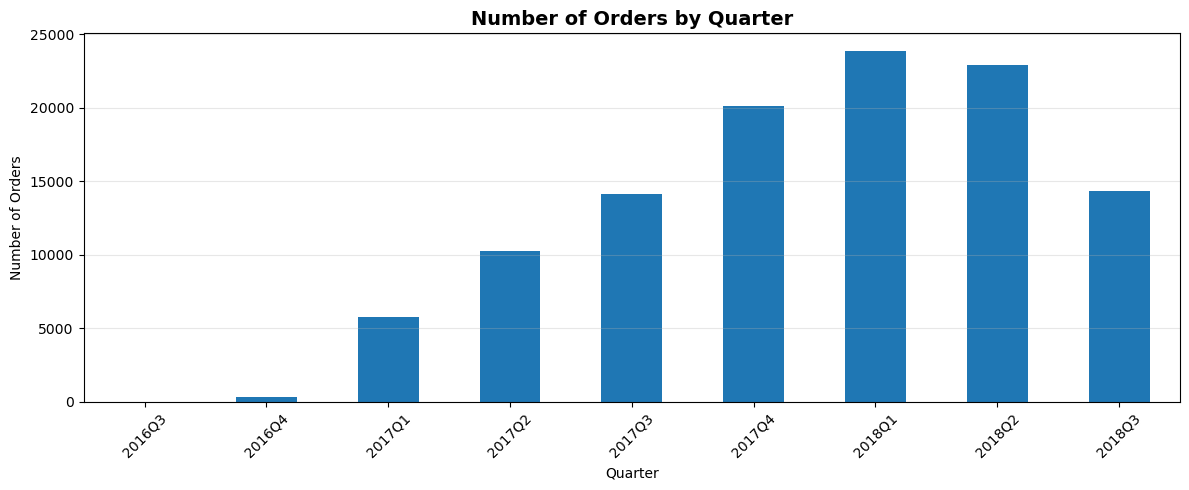

In [43]:
# Visualize quarterly distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
quarter_counts.plot(kind='bar')
plt.title('Number of Orders by Quarter', fontsize=14, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

**Key Observations:**
- There are 9 quarters of data (2016Q3 to 2018Q3)
- Growth trend: orders increase over time
- Some quarters (like 2016Q3, 2016Q4, 2018Q3) have very few orders (edge cases)

---

### **2.3. Seller Activity Data**


In [44]:
# Aggregate to seller-quarter level
seller_quarter_activity = df_approved.groupby(['seller_id', 'quarter']).agg({
    'order_id': 'count',  # Number of orders
    'price': 'sum',       # Total revenue
    'freight_value': 'sum',  # Total freight
    'order_approved_at': ['min', 'max']  # First and last order dates
}).reset_index()


seller_quarter_activity.columns = [ 'seller_id', 'quarter', 'num_orders', 'total_revenue', 
    'total_freight', 'first_order_date', 'last_order_date'] #changing the column names

seller_quarter_activity.head(10)

,seller_id,quarter,num_orders,total_revenue,total_freight,first_order_date,last_order_date
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1,895.00,21.02,2017-09-27 22:24:16,2017-09-27 22:24:16
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2,1790.00,42.04,2017-10-12 13:49:22,2017-10-18 23:56:20
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28,2775.60,643.80,2017-02-04 19:15:39,2017-03-31 15:55:19
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,64,6746.68,2125.04,2017-04-02 19:05:11,2017-06-30 11:23:43
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,55,5619.95,2243.22,2017-07-01 04:50:17,2017-09-29 18:28:18
5,001cca7ae9ae17fb1caed9dfb1094831,2017Q4,63,6496.00,2416.26,2017-10-03 12:56:48,2017-12-29 02:09:49
6,001cca7ae9ae17fb1caed9dfb1094831,2018Q1,17,1950.90,713.72,2018-01-01 21:06:39,2018-03-31 10:07:45
7,001cca7ae9ae17fb1caed9dfb1094831,2018Q2,11,1361.00,675.96,2018-04-03 05:35:33,2018-06-20 09:20:22
8,001cca7ae9ae17fb1caed9dfb1094831,2018Q3,1,129.90,36.14,2018-07-12 21:50:17,2018-07-12 21:50:17
9,002100f778ceb8431b7a1020ff7ab48f,2017Q3,3,33.70,38.80,2017-09-14 01:10:15,2017-09-22 05:36:14


Because not every seller is active in every quarter, we need to create a grid that includes inactive quarters with 0 orders so the churned seller can be identified

In [45]:
all_sellers = df_approved['seller_id'].unique()
quarters_list = all_quarters

print(f"Number of sellers: {len(all_sellers):,}")
print(f"Number of quarters: {len(quarters_list)}")

Number of sellers: 2,987
Number of quarters: 9


In [46]:
from itertools import product

In [47]:
# Create all possible seller-quarter combinations
all_combinations = pd.DataFrame(
    list(product(all_sellers, quarters_list)),
    columns=['seller_id', 'quarter'] #this will create every possible combination out of all the seller_id and quarters that are available
)

all_combinations.head()

,seller_id,quarter
0,3442f8959a84dea7ee197c632cb2df15,2016Q3
1,3442f8959a84dea7ee197c632cb2df15,2016Q4
2,3442f8959a84dea7ee197c632cb2df15,2017Q1
3,3442f8959a84dea7ee197c632cb2df15,2017Q2
4,3442f8959a84dea7ee197c632cb2df15,2017Q3


In [48]:
# Merge with actual activity

seller_quarter_full = all_combinations.merge(seller_quarter_activity,
on=['seller_id', 'quarter'], #there are 2 key columns. In order to be merge, both values has to be identical from one df to the other one
how='left'
)

# Create is_active flag (True if seller had orders, False if inactive)
seller_quarter_full['is_active'] = seller_quarter_full['num_orders'].notna()

# Fill missing values with 0 for numeric columns
seller_quarter_full['num_orders'] = seller_quarter_full['num_orders'].fillna(0)
seller_quarter_full['total_revenue'] = seller_quarter_full['total_revenue'].fillna(0)
seller_quarter_full['total_freight'] = seller_quarter_full['total_freight'].fillna(0)

print(f"Full grid: {len(seller_quarter_full):,} seller-quarter combinations")
print(f"Active combinations: {seller_quarter_full['is_active'].sum():,}")
print(f"Inactive combinations: {(~seller_quarter_full['is_active']).sum():,}")

seller_quarter_full.head(20)

Full grid: 26,883 seller-quarter combinations
Active combinations: 8,373
Inactive combinations: 18,510


,seller_id,quarter,num_orders,total_revenue,total_freight,first_order_date,last_order_date,is_active
0,3442f8959a84dea7ee197c632cb2df15,2016Q3,0.0,0.00,0.00,NaT,NaT,False
1,3442f8959a84dea7ee197c632cb2df15,2016Q4,0.0,0.00,0.00,NaT,NaT,False
2,3442f8959a84dea7ee197c632cb2df15,2017Q1,0.0,0.00,0.00,NaT,NaT,False
3,3442f8959a84dea7ee197c632cb2df15,2017Q2,1.0,101.70,15.92,2017-05-05 16:25:11,2017-05-05 16:25:11,True
4,3442f8959a84dea7ee197c632cb2df15,2017Q3,2.0,117.00,11.98,2017-08-21 20:50:19,2017-08-30 12:50:19,True
5,3442f8959a84dea7ee197c632cb2df15,2017Q4,0.0,0.00,0.00,NaT,NaT,False
6,3442f8959a84dea7ee197c632cb2df15,2018Q1,0.0,0.00,0.00,NaT,NaT,False
7,3442f8959a84dea7ee197c632cb2df15,2018Q2,0.0,0.00,0.00,NaT,NaT,False
8,3442f8959a84dea7ee197c632cb2df15,2018Q3,0.0,0.00,0.00,NaT,NaT,False
9,d1b65fc7debc3361ea86b5f14c68d2e2,2016Q3,0.0,0.00,0.00,NaT,NaT,False


### **2.4 Seller Churn Label**

**Churn Definition:**
- IF (seller is active in quarter Q) AND (seller is NOT active in quarter Q+1)
- THEN churned = 1
- ELSE churned = 0

In [49]:
# Sort by seller and quarter to ensure proper ordering
seller_quarter_full = seller_quarter_full.sort_values(['seller_id', 'quarter']).reset_index(drop=True)

# Create next quarter activity indicator using shift
# For each seller, shift is_active down by 1 row (gets next quarter's status)
seller_quarter_full['next_quarter_active'] = seller_quarter_full.groupby('seller_id')['is_active'].shift(-1)


# Preview - see current quarter vs next quarter
seller_quarter_full[['seller_id', 'quarter', 'is_active', 'next_quarter_active']].head(20)

,seller_id,quarter,is_active,next_quarter_active
0,0015a82c2db000af6aaaf3ae2ecb0532,2016Q3,False,False
1,0015a82c2db000af6aaaf3ae2ecb0532,2016Q4,False,False
2,0015a82c2db000af6aaaf3ae2ecb0532,2017Q1,False,False
3,0015a82c2db000af6aaaf3ae2ecb0532,2017Q2,False,True
4,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,True,True
5,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,True,False
6,0015a82c2db000af6aaaf3ae2ecb0532,2018Q1,False,False
7,0015a82c2db000af6aaaf3ae2ecb0532,2018Q2,False,False
8,0015a82c2db000af6aaaf3ae2ecb0532,2018Q3,False,NaN
9,001cca7ae9ae17fb1caed9dfb1094831,2016Q3,False,False


In [50]:
# Define churn
seller_quarter_full['churned'] = (
    (seller_quarter_full['is_active'] == True) & 
    (seller_quarter_full['next_quarter_active'] == False)
).astype(int)

# Calculate churn statistics
active_quarters = seller_quarter_full[seller_quarter_full['is_active'] == True]
churned_quarters = seller_quarter_full[seller_quarter_full['churned'] == 1]

print("\nChurn Statistics:")
print("="*60)
print(f"Total active seller-quarters: {len(active_quarters):,}")
print(f"Churned seller-quarters: {len(churned_quarters):,}")
print(f"Churn rate: {len(churned_quarters)/len(active_quarters)*100:.2f}%")


Churn Statistics:
Total active seller-quarters: 8,373
Churned seller-quarters: 1,658
Churn rate: 19.80%


Churn Rate by Quarter:
         sum  count  churn_rate
quarter                        
2016Q3     0      1    0.000000
2016Q4    35    132   26.515152
2017Q1   144    623   23.113965
2017Q2   190    782   24.296675
2017Q3   198    976   20.286885
2017Q4   296   1240   23.870968
2018Q1   322   1356   23.746313
2018Q2   473   1655   28.580060
2018Q3     0   1608    0.000000


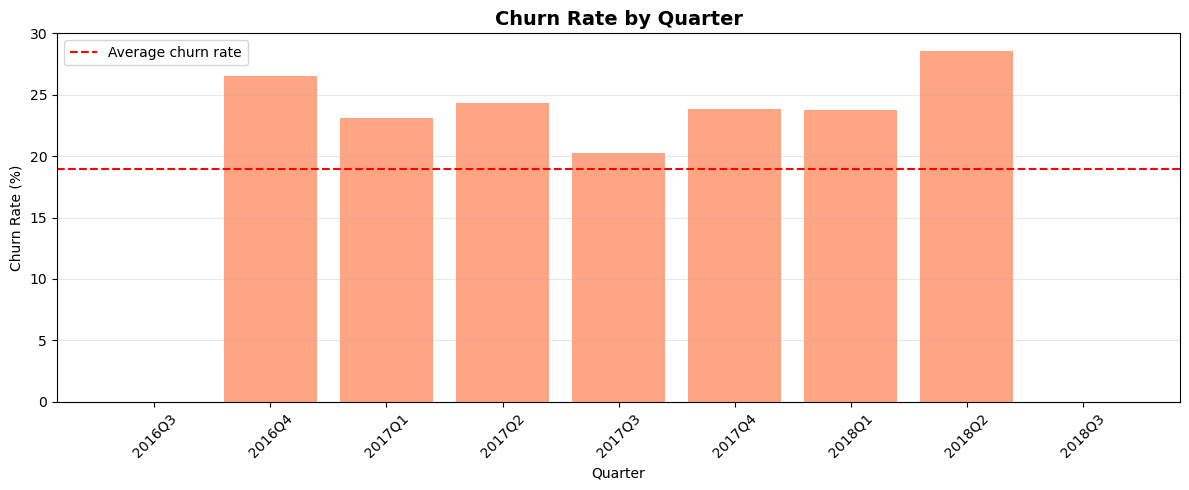

In [51]:
# Visualize churn by quarter
churn_by_quarter = seller_quarter_full[seller_quarter_full['is_active']].groupby('quarter')['churned'].agg(['sum', 'count', 'mean'])
churn_by_quarter['churn_rate'] = churn_by_quarter['mean'] * 100

print("Churn Rate by Quarter:")
print("="*60)
print(churn_by_quarter[['sum', 'count', 'churn_rate']])

# Plot
plt.figure(figsize=(12, 5))
plt.bar(range(len(churn_by_quarter)), churn_by_quarter['churn_rate'], color='coral', alpha=0.7)
plt.axhline(y=churn_by_quarter['churn_rate'].mean(), color='red', linestyle='--', label='Average churn rate')
plt.title('Churn Rate by Quarter', fontsize=14, fontweight='bold')
plt.xlabel('Quarter')
plt.ylabel('Churn Rate (%)')
plt.xticks(range(len(churn_by_quarter)), churn_by_quarter.index, rotation=45)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

### **2.5. Seller Chrun Features**

In [52]:
seller_quarter_full

,seller_id,quarter,num_orders,total_revenue,total_freight,first_order_date,last_order_date,is_active,next_quarter_active,churned
0,0015a82c2db000af6aaaf3ae2ecb0532,2016Q3,0.0,0.0,0.00,NaT,NaT,False,False,0
1,0015a82c2db000af6aaaf3ae2ecb0532,2016Q4,0.0,0.0,0.00,NaT,NaT,False,False,0
2,0015a82c2db000af6aaaf3ae2ecb0532,2017Q1,0.0,0.0,0.00,NaT,NaT,False,False,0
3,0015a82c2db000af6aaaf3ae2ecb0532,2017Q2,0.0,0.0,0.00,NaT,NaT,False,True,0
4,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,895.0,21.02,2017-09-27 22:24:16,2017-09-27 22:24:16,True,True,0
...,...,...,...,...,...,...,...,...,...,...
26878,ffff564a4f9085cd26170f4732393726,2017Q3,0.0,0.0,0.00,NaT,NaT,False,False,0
26879,ffff564a4f9085cd26170f4732393726,2017Q4,0.0,0.0,0.00,NaT,NaT,False,False,0
26880,ffff564a4f9085cd26170f4732393726,2018Q1,0.0,0.0,0.00,NaT,NaT,False,False,0
26881,ffff564a4f9085cd26170f4732393726,2018Q2,0.0,0.0,0.00,NaT,NaT,False,False,0


In [53]:
# Filter to active seller-quarters only (can't predict churn for inactive sellers)
feature_df = seller_quarter_full[seller_quarter_full['is_active'] == True].copy()

print(f"Starting with {len(feature_df):,} active seller-quarters")

# Current quarter features (already have num_orders, total_revenue, total_freight)
# Add derived metrics

# Average order value
feature_df['avg_order_value'] = np.where(
    feature_df['num_orders'] > 0,
    feature_df['total_revenue'] / feature_df['num_orders'],
    0
)

# Days active in quarter (from first to last order)
feature_df['days_active_in_quarter'] = (
    feature_df['last_order_date'] - feature_df['first_order_date']
).dt.days

print("Created current quarter features:")
print("  - num_orders")
print("  - total_revenue")
print("  - total_freight")
print("  - avg_order_value")
print("  - days_active_in_quarter")

feature_df[['seller_id', 'quarter', 'num_orders', 'total_revenue', 'avg_order_value', 'days_active_in_quarter']].head()

Starting with 8,373 active seller-quarters
Created current quarter features:
  - num_orders
  - total_revenue
  - total_freight
  - avg_order_value
  - days_active_in_quarter


,seller_id,quarter,num_orders,total_revenue,avg_order_value,days_active_in_quarter
4,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,895.00,895.000000,0
5,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2.0,1790.00,895.000000,6
11,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28.0,2775.60,99.128571,54
12,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,64.0,6746.68,105.416875,88
13,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,55.0,5619.95,102.180909,90


In [54]:
# Get category information per seller per quarter from original data
seller_quarter_categories = df_approved.groupby(['seller_id', 'quarter']).agg({
    'product_category_name_english': lambda x: x.nunique()
}).reset_index()
seller_quarter_categories.columns = ['seller_id', 'quarter', 'num_categories']

# Merge with feature dataframe
feature_df = feature_df.merge(seller_quarter_categories, on=['seller_id', 'quarter'], how='left')
feature_df['num_categories'] = feature_df['num_categories'].fillna(1)

print("✓ Added: num_categories")
print(f"  Average categories per seller: {feature_df['num_categories'].mean():.2f}")

feature_df[['seller_id', 'quarter', 'num_orders', 'num_categories']].head()

✓ Added: num_categories
  Average categories per seller: 1.74


,seller_id,quarter,num_orders,num_categories
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,1
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2.0,1
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28.0,1
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,64.0,2
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,55.0,2


In [55]:
# Previous quarter metrics (shift by 1 within each seller)
for col in ['num_orders', 'total_revenue', 'total_freight']:
    feature_df[f'prev_quarter_{col}'] = feature_df.groupby('seller_id')[col].shift(1).fillna(0)

# Calculate change from previous quarter
feature_df['orders_change_from_prev'] = (
    feature_df['num_orders'] - feature_df['prev_quarter_num_orders']
)
feature_df['revenue_change_from_prev'] = (
    feature_df['total_revenue'] - feature_df['prev_quarter_total_revenue']
)

print("✓ Created historical comparison features:")
print("  - prev_quarter_num_orders")
print("  - prev_quarter_total_revenue")
print("  - prev_quarter_total_freight")
print("  - orders_change_from_prev")
print("  - revenue_change_from_prev")

feature_df[['seller_id', 'quarter', 'num_orders', 'prev_quarter_num_orders', 'orders_change_from_prev']].head(10)

✓ Created historical comparison features:
  - prev_quarter_num_orders
  - prev_quarter_total_revenue
  - prev_quarter_total_freight
  - orders_change_from_prev
  - revenue_change_from_prev


,seller_id,quarter,num_orders,prev_quarter_num_orders,orders_change_from_prev
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,0.0,1.0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2.0,1.0,1.0
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28.0,0.0,28.0
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,64.0,28.0,36.0
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,55.0,64.0,-9.0
5,001cca7ae9ae17fb1caed9dfb1094831,2017Q4,63.0,55.0,8.0
6,001cca7ae9ae17fb1caed9dfb1094831,2018Q1,17.0,63.0,-46.0
7,001cca7ae9ae17fb1caed9dfb1094831,2018Q2,11.0,17.0,-6.0
8,001cca7ae9ae17fb1caed9dfb1094831,2018Q3,1.0,11.0,-10.0
9,002100f778ceb8431b7a1020ff7ab48f,2017Q3,3.0,0.0,3.0


In [56]:
# Last 2 quarters average
for col in ['num_orders', 'total_revenue']:
    feature_df[f'avg_{col}_last_2q'] = (
        feature_df.groupby('seller_id')[col]
        .rolling(window=2, min_periods=1)
        .mean()
        .reset_index(level=0, drop=True)
    )

# Lifetime metrics (cumulative sum)
feature_df['lifetime_orders'] = feature_df.groupby('seller_id')['num_orders'].cumsum()
feature_df['lifetime_revenue'] = feature_df.groupby('seller_id')['total_revenue'].cumsum()

print("Created rolling aggregate features:")
print("  - avg_num_orders_last_2q")
print("  - avg_total_revenue_last_2q")
print("  - lifetime_orders")
print("  - lifetime_revenue")

feature_df[['seller_id', 'quarter', 'num_orders', 'avg_num_orders_last_2q', 'lifetime_orders']].head(10)

Created rolling aggregate features:
  - avg_num_orders_last_2q
  - avg_total_revenue_last_2q
  - lifetime_orders
  - lifetime_revenue


,seller_id,quarter,num_orders,avg_num_orders_last_2q,lifetime_orders
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,1.0,1.0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2.0,1.5,3.0
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28.0,28.0,28.0
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,64.0,46.0,92.0
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,55.0,59.5,147.0
5,001cca7ae9ae17fb1caed9dfb1094831,2017Q4,63.0,59.0,210.0
6,001cca7ae9ae17fb1caed9dfb1094831,2018Q1,17.0,40.0,227.0
7,001cca7ae9ae17fb1caed9dfb1094831,2018Q2,11.0,14.0,238.0
8,001cca7ae9ae17fb1caed9dfb1094831,2018Q3,1.0,6.0,239.0
9,002100f778ceb8431b7a1020ff7ab48f,2017Q3,3.0,3.0,3.0


In [57]:
# Number of previous active quarters
feature_df['num_previous_active_quarters'] = feature_df.groupby('seller_id')['is_active'].cumsum() - 1

# Tenure (rank of quarters)
feature_df['tenure_quarters'] = (
    feature_df.groupby('seller_id')['quarter']
    .rank(method='dense')
    .astype(int)
)

# Quarters since first appearance
seller_first_quarter = feature_df.groupby('seller_id')['quarter'].min().reset_index()
seller_first_quarter.columns = ['seller_id', 'first_quarter']
feature_df = feature_df.merge(seller_first_quarter, on='seller_id', how='left')

feature_df['quarters_since_first'] = feature_df.apply(
    lambda row: (row['quarter'] - row['first_quarter']).n if pd.notna(row['quarter']) else 0,
    axis=1
)

print("Created tenure features:")
print("  - tenure_quarters")
print("  - quarters_since_first")
print("  - num_previous_active_quarters")

feature_df[['seller_id', 'quarter', 'tenure_quarters', 'quarters_since_first', 'num_previous_active_quarters']].head(10)

Created tenure features:
  - tenure_quarters
  - quarters_since_first
  - num_previous_active_quarters


,seller_id,quarter,tenure_quarters,quarters_since_first,num_previous_active_quarters
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1,0,0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2,1,1
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,1,0,0
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,2,1,1
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,3,2,2
5,001cca7ae9ae17fb1caed9dfb1094831,2017Q4,4,3,3
6,001cca7ae9ae17fb1caed9dfb1094831,2018Q1,5,4,4
7,001cca7ae9ae17fb1caed9dfb1094831,2018Q2,6,5,5
8,001cca7ae9ae17fb1caed9dfb1094831,2018Q3,7,6,6
9,002100f778ceb8431b7a1020ff7ab48f,2017Q3,1,0,0


In [58]:
# Growth/decline indicators
feature_df['is_growing'] = (feature_df['orders_change_from_prev'] > 0).astype(int)
feature_df['is_declining'] = (feature_df['orders_change_from_prev'] < 0).astype(int)

# Consecutive quarters of decline
def get_consecutive_declines(group):
    """Calculate consecutive quarters of decline for each row"""
    declines = (group['orders_change_from_prev'] < 0).astype(int)
    consecutive = []
    count = 0
    for val in declines:
        if val == 1:
            count += 1
        else:
            count = 0
        consecutive.append(count)
    return pd.Series(consecutive, index=group.index)

feature_df['consecutive_declines'] = (
    feature_df.groupby('seller_id', group_keys=False)
    .apply(get_consecutive_declines)
)

print("Created trend features:")
print("  - is_growing")
print("  - is_declining")
print("  - consecutive_declines")

feature_df[['seller_id', 'quarter', 'orders_change_from_prev', 'is_growing', 'is_declining', 'consecutive_declines']].head(15)

Created trend features:
  - is_growing
  - is_declining
  - consecutive_declines


C:\Users\Hp\AppData\Local\Temp\ipykernel_29676\4119325477.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(get_consecutive_declines)


,seller_id,quarter,orders_change_from_prev,is_growing,is_declining,consecutive_declines
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,1,0,0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,1.0,1,0,0
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28.0,1,0,0
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,36.0,1,0,0
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,-9.0,0,1,1
5,001cca7ae9ae17fb1caed9dfb1094831,2017Q4,8.0,1,0,0
6,001cca7ae9ae17fb1caed9dfb1094831,2018Q1,-46.0,0,1,1
7,001cca7ae9ae17fb1caed9dfb1094831,2018Q2,-6.0,0,1,2
8,001cca7ae9ae17fb1caed9dfb1094831,2018Q3,-10.0,0,1,3
9,002100f778ceb8431b7a1020ff7ab48f,2017Q3,3.0,1,0,0


In [59]:
# Extract quarter number and year
feature_df['quarter_of_year'] = feature_df['quarter'].dt.quarter
feature_df['year'] = feature_df['quarter'].dt.year

# Q4 indicator (holiday season)
feature_df['is_q4'] = (feature_df['quarter_of_year'] == 4).astype(int)

print("Created temporal features:")
print("  - quarter_of_year")
print("  - year")
print("  - is_q4")

feature_df[['seller_id', 'quarter', 'quarter_of_year', 'year', 'is_q4']].head()

Created temporal features:
  - quarter_of_year
  - year
  - is_q4


,seller_id,quarter,quarter_of_year,year,is_q4
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,3,2017,0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,4,2017,1
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,1,2017,0
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,2,2017,0
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,3,2017,0


In [60]:
feature_columns = [
    # Current quarter performance (6)
    'num_orders', 'total_revenue', 'total_freight', 'avg_order_value',
    'days_active_in_quarter', 'num_categories',
    
    # Historical comparisons (5)
    'prev_quarter_num_orders', 'prev_quarter_total_revenue', 'prev_quarter_total_freight',
    'orders_change_from_prev', 'revenue_change_from_prev',
    
    # Rolling aggregates (4)
    'avg_num_orders_last_2q', 'avg_total_revenue_last_2q',
    'lifetime_orders', 'lifetime_revenue',
    
    # Tenure (3)
    'tenure_quarters', 'quarters_since_first', 'num_previous_active_quarters',
    
    # Trends (3)
    'is_growing', 'is_declining', 'consecutive_declines',
    
    # Temporal (3)
    'quarter_of_year', 'year', 'is_q4'
]

print(f"Total features created: {len(feature_columns)}")
print("\nFeature categories:")
print("  1. Current Quarter Performance: 6 features")
print("  2. Historical Comparison: 5 features")
print("  3. Rolling Aggregates: 4 features")
print("  4. Tenure: 3 features")
print("  5. Trends: 3 features")
print("  6. Temporal: 3 features")

Total features created: 24

Feature categories:
  1. Current Quarter Performance: 6 features
  2. Historical Comparison: 5 features
  3. Rolling Aggregates: 4 features
  4. Tenure: 3 features
  5. Trends: 3 features
  6. Temporal: 3 features


### **2.6 Final Dataset Preparation**

In [61]:
# Identify the last quarter (can't observe churn for it)
last_quarter = all_quarters[-1]
feature_df['is_last_quarter'] = feature_df['quarter'] == last_quarter

print(f"Last quarter: {last_quarter}")
print(f"Observations in last quarter: {feature_df['is_last_quarter'].sum()}")

# Remove last quarter from modeling dataset
feature_df_final = feature_df[~feature_df['is_last_quarter']].copy()

print(f"\nBefore removing last quarter: {len(feature_df):,} observations")
print(f"After removing last quarter: {len(feature_df_final):,} observations")

Last quarter: 2018Q3
Observations in last quarter: 1608

Before removing last quarter: 8,373 observations
After removing last quarter: 6,765 observations


In [62]:
feature_df

,seller_id,quarter,num_orders,total_revenue,total_freight,first_order_date,last_order_date,is_active,next_quarter_active,churned,avg_order_value,days_active_in_quarter,num_categories,prev_quarter_num_orders,prev_quarter_total_revenue,prev_quarter_total_freight,orders_change_from_prev,revenue_change_from_prev,avg_num_orders_last_2q,avg_total_revenue_last_2q,lifetime_orders,lifetime_revenue,num_previous_active_quarters,tenure_quarters,first_quarter,quarters_since_first,is_growing,is_declining,consecutive_declines,quarter_of_year,year,is_q4,is_last_quarter
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,1.0,895.00,21.02,2017-09-27 22:24:16,2017-09-27 22:24:16,True,True,0,895.000000,0,1,0.0,0.00,0.00,1.0,895.00,1.0,895.000,1.0,895.00,0,1,2017Q3,0,1,0,0,3,2017,0,False
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,2.0,1790.00,42.04,2017-10-12 13:49:22,2017-10-18 23:56:20,True,False,1,895.000000,6,1,1.0,895.00,21.02,1.0,895.00,1.5,1342.500,3.0,2685.00,1,2,2017Q3,1,1,0,0,4,2017,1,False
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,28.0,2775.60,643.80,2017-02-04 19:15:39,2017-03-31 15:55:19,True,True,0,99.128571,54,1,0.0,0.00,0.00,28.0,2775.60,28.0,2775.600,28.0,2775.60,0,1,2017Q1,0,1,0,0,1,2017,0,False
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,64.0,6746.68,2125.04,2017-04-02 19:05:11,2017-06-30 11:23:43,True,True,0,105.416875,88,2,28.0,2775.60,643.80,36.0,3971.08,46.0,4761.140,92.0,9522.28,1,2,2017Q1,1,1,0,0,2,2017,0,False
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,55.0,5619.95,2243.22,2017-07-01 04:50:17,2017-09-29 18:28:18,True,True,0,102.180909,90,2,64.0,6746.68,2125.04,-9.0,-1126.73,59.5,6183.315,147.0,15142.23,2,3,2017Q1,2,0,1,1,3,2017,0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8368,fffd5413c0700ac820c7069d66d98c89,2018Q1,20.0,3050.40,1057.63,2018-01-06 15:31:49,2018-03-17 08:35:24,True,True,0,152.520000,69,2,15.0,2301.60,639.11,5.0,748.80,17.5,2676.000,40.0,6424.70,2,3,2017Q3,2,1,0,0,1,2018,0,False
8369,fffd5413c0700ac820c7069d66d98c89,2018Q2,14.0,1766.40,706.53,2018-04-06 16:35:24,2018-06-15 08:56:05,True,True,0,126.171429,69,3,20.0,3050.40,1057.63,-6.0,-1284.00,17.0,2408.400,54.0,8191.10,3,4,2017Q3,3,0,1,1,2,2018,0,False
8370,fffd5413c0700ac820c7069d66d98c89,2018Q3,6.0,771.40,242.87,2018-07-16 10:04:26,2018-08-26 20:10:15,True,NaN,0,128.566667,41,2,14.0,1766.40,706.53,-8.0,-995.00,10.0,1268.900,60.0,8962.50,4,5,2017Q3,4,0,1,2,3,2018,0,True
8371,ffff564a4f9085cd26170f4732393726,2016Q4,2.0,120.50,26.47,2016-10-07 18:01:40,2016-10-10 16:02:39,True,True,0,60.250000,2,2,0.0,0.00,0.00,2.0,120.50,2.0,120.500,2.0,120.50,0,1,2016Q4,0,1,0,0,4,2016,1,False


In [63]:
# Create final dataset with selected columns
model_data = feature_df_final[['seller_id', 'quarter', 'churned'] + feature_columns].copy()

print("Final Dataset Shape:")
print("="*60)
print(f"Rows (observations): {len(model_data):,}")
print(f"Columns: {len(model_data.columns)}")
print(f"  - seller_id: identifier")
print(f"  - quarter: time period")
print(f"  - churned: target variable (0 or 1)")
print(f"  - {len(feature_columns)} features")

print("\nClass Distribution:")
print("="*60)
print(model_data['churned'].value_counts())
print(f"\nChurn rate: {model_data['churned'].mean()*100:.2f}%")
print(f"Not churned: {(model_data['churned'] == 0).sum()/len(model_data)*100:.2f}%")
print(f"Churned: {(model_data['churned'] == 1).sum()/len(model_data)*100:.2f}%")

Final Dataset Shape:
Rows (observations): 6,765
Columns: 27
  - seller_id: identifier
  - quarter: time period
  - churned: target variable (0 or 1)
  - 24 features

Class Distribution:
churned
0    5107
1    1658
Name: count, dtype: int64

Churn rate: 24.51%
Not churned: 75.49%
Churned: 24.51%


In [64]:
# Preview final dataset
print("Preview of Final Dataset:")
print("="*60)
model_data.head(10)

Preview of Final Dataset:


,seller_id,quarter,churned,num_orders,total_revenue,total_freight,avg_order_value,days_active_in_quarter,num_categories,prev_quarter_num_orders,prev_quarter_total_revenue,prev_quarter_total_freight,orders_change_from_prev,revenue_change_from_prev,avg_num_orders_last_2q,avg_total_revenue_last_2q,lifetime_orders,lifetime_revenue,tenure_quarters,quarters_since_first,num_previous_active_quarters,is_growing,is_declining,consecutive_declines,quarter_of_year,year,is_q4
0,0015a82c2db000af6aaaf3ae2ecb0532,2017Q3,0,1.0,895.00,21.02,895.000000,0,1,0.0,0.00,0.00,1.0,895.00,1.0,895.000,1.0,895.00,1,0,0,1,0,0,3,2017,0
1,0015a82c2db000af6aaaf3ae2ecb0532,2017Q4,1,2.0,1790.00,42.04,895.000000,6,1,1.0,895.00,21.02,1.0,895.00,1.5,1342.500,3.0,2685.00,2,1,1,1,0,0,4,2017,1
2,001cca7ae9ae17fb1caed9dfb1094831,2017Q1,0,28.0,2775.60,643.80,99.128571,54,1,0.0,0.00,0.00,28.0,2775.60,28.0,2775.600,28.0,2775.60,1,0,0,1,0,0,1,2017,0
3,001cca7ae9ae17fb1caed9dfb1094831,2017Q2,0,64.0,6746.68,2125.04,105.416875,88,2,28.0,2775.60,643.80,36.0,3971.08,46.0,4761.140,92.0,9522.28,2,1,1,1,0,0,2,2017,0
4,001cca7ae9ae17fb1caed9dfb1094831,2017Q3,0,55.0,5619.95,2243.22,102.180909,90,2,64.0,6746.68,2125.04,-9.0,-1126.73,59.5,6183.315,147.0,15142.23,3,2,2,0,1,1,3,2017,0
5,001cca7ae9ae17fb1caed9dfb1094831,2017Q4,0,63.0,6496.00,2416.26,103.111111,86,2,55.0,5619.95,2243.22,8.0,876.05,59.0,6057.975,210.0,21638.23,4,3,3,1,0,0,4,2017,1
6,001cca7ae9ae17fb1caed9dfb1094831,2018Q1,0,17.0,1950.90,713.72,114.758824,88,2,63.0,6496.00,2416.26,-46.0,-4545.10,40.0,4223.450,227.0,23589.13,5,4,4,0,1,1,1,2018,0
7,001cca7ae9ae17fb1caed9dfb1094831,2018Q2,0,11.0,1361.00,675.96,123.727273,78,2,17.0,1950.90,713.72,-6.0,-589.90,14.0,1655.950,238.0,24950.13,6,5,5,0,1,2,2,2018,0
9,002100f778ceb8431b7a1020ff7ab48f,2017Q3,0,3.0,33.70,38.80,11.233333,8,1,0.0,0.00,0.00,3.0,33.70,3.0,33.700,3.0,33.70,1,0,0,1,0,0,3,2017,0
10,002100f778ceb8431b7a1020ff7ab48f,2017Q4,0,40.0,766.00,569.83,19.150000,88,1,3.0,33.70,38.80,37.0,732.30,21.5,399.850,43.0,799.70,2,1,1,1,0,0,4,2017,1


In [65]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6765 entries, 0 to 8372
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype        
---  ------                        --------------  -----        
 0   seller_id                     6765 non-null   object       
 1   quarter                       6765 non-null   period[Q-DEC]
 2   churned                       6765 non-null   int64        
 3   num_orders                    6765 non-null   float64      
 4   total_revenue                 6765 non-null   float64      
 5   total_freight                 6765 non-null   float64      
 6   avg_order_value               6765 non-null   float64      
 7   days_active_in_quarter        6765 non-null   int64        
 8   num_categories                6765 non-null   int64        
 9   prev_quarter_num_orders       6765 non-null   float64      
 10  prev_quarter_total_revenue    6765 non-null   float64      
 11  prev_quarter_total_freight    6765 non-null   fl

In [66]:
model_data.isna().sum()

seller_id                       0
quarter                         0
churned                         0
num_orders                      0
total_revenue                   0
total_freight                   0
avg_order_value                 0
days_active_in_quarter          0
num_categories                  0
prev_quarter_num_orders         0
prev_quarter_total_revenue      0
prev_quarter_total_freight      0
orders_change_from_prev         0
revenue_change_from_prev        0
avg_num_orders_last_2q          0
avg_total_revenue_last_2q       0
lifetime_orders                 0
lifetime_revenue                0
tenure_quarters                 0
quarters_since_first            0
num_previous_active_quarters    0
is_growing                      0
is_declining                    0
consecutive_declines            0
quarter_of_year                 0
year                            0
is_q4                           0
dtype: int64

In [67]:
model_data.to_csv("seller_churn_dataset", index=False)

### **2.7 Comparing Churned vs Not Churned**

In [68]:
# Compare key metrics
comparison_features = [
    'num_orders', 'total_revenue', 'avg_order_value', 
    'tenure_quarters', 'consecutive_declines', 'num_categories'
]

comparison_df = pd.DataFrame({
    'Feature': comparison_features,
    'Not Churned': [model_data[model_data['churned'] == 0][f].mean() for f in comparison_features],
    'Churned': [model_data[model_data['churned'] == 1][f].mean() for f in comparison_features]
})

comparison_df['Difference'] = comparison_df['Churned'] - comparison_df['Not Churned']
comparison_df['% Difference'] = (comparison_df['Difference'] / comparison_df['Not Churned'] * 100).round(2)

print("Churned vs Not Churned - Feature Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))

Churned vs Not Churned - Feature Comparison:
             Feature  Not Churned    Churned   Difference  % Difference
          num_orders    17.930879   3.533776   -14.397104        -80.29
       total_revenue  2107.536417 565.559723 -1541.976694        -73.16
     avg_order_value   158.206458 196.028309    37.821851         23.91
     tenure_quarters     2.423145   2.120024    -0.303121        -12.51
consecutive_declines     0.294302   0.346803     0.052501         17.84
      num_categories     1.912277   1.280458    -0.631819        -33.04


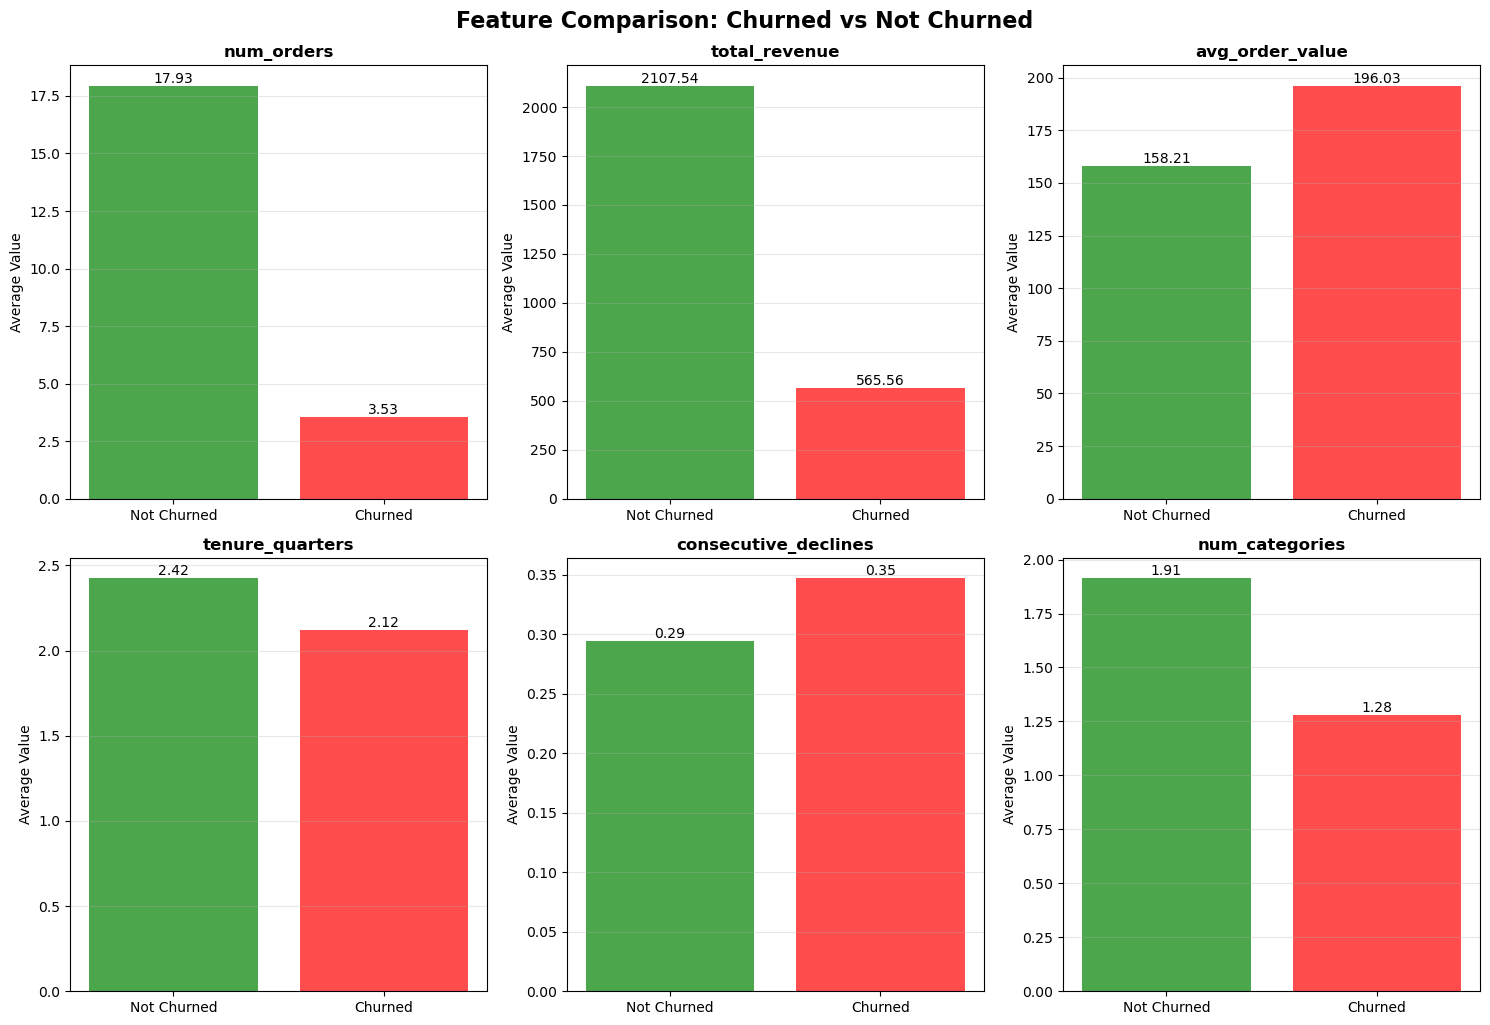

In [69]:
# Visualize the comparison
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for idx, feature in enumerate(comparison_features):
    ax = axes[idx]
    
    # Create side-by-side bars
    not_churned_val = model_data[model_data['churned'] == 0][feature].mean()
    churned_val = model_data[model_data['churned'] == 1][feature].mean()
    
    ax.bar(['Not Churned', 'Churned'], [not_churned_val, churned_val], 
           color=['green', 'red'], alpha=0.7)
    ax.set_title(feature, fontweight='bold')
    ax.set_ylabel('Average Value')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels
    ax.text(0, not_churned_val, f'{not_churned_val:.2f}', ha='center', va='bottom')
    ax.text(1, churned_val, f'{churned_val:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.suptitle('Feature Comparison: Churned vs Not Churned', fontsize=16, fontweight='bold', y=1.02)
plt.show()

**Key Insights:**
- Churned sellers have 80% fewer orders (3.53 vs 17.93)
- Churned sellers generate 73% less revenue ($565.56 vs $2,107.54)
- Churned sellers have slightly higher avg order value (less volume, higher prices)
- Churned sellers have lower category diversity (1.28 vs 1.91 categories)


## **3. Churn Prediction Modeling**

In [70]:
base_dir = "D:\\Purwadhika\\Finpro\\Dataset\\"
df = pd.read_csv(base_dir + "seller_churn_dataset")

### **3.1 Introduction**

#### **3.1.1 Context**

Olist is the #1 commerce enabler for small and medium-sized businesses (SMBs) in Brazil, now expanding globally. Founded in 2015 by Tiago Dalvi and based in Curitiba, Brazil, the company became a unicorn in 2021 with a valuation of $1.5 billion Tracxn. Olist operates as a comprehensive e-commerce ecosystem that helps SMBs sell online by providing integrated solutions across three main dimensions: commerce (including marketplace integration and e-commerce solutions), logistics (through Olist Pax, their cloud-based fulfillment network), and capital (via Olist Credit and Olist Pay).

Olist connects sellers to marketplaces Meta, making it easier for small businesses to sell their products across multiple platforms without managing each marketplace separately. The company's core offering, Olist Store, allows merchants to list and sell their products on major marketplaces like Amazon and Mercado Livre through a single integration. The platform includes ERP systems, digital accounts, integration hubs, point-of-sale systems, and e-commerce solutions ZoomInfo that streamline and automate business management. Merchants can manage their listings, inventory, orders, and shipment tracking all from one centralized platform. The system handles the complexity of synchronizing orders and inventory across multiple marketplaces, while Olist's logistics network (Olist Pax) provides shipping and fulfillment services.



#### **3.1.2 Goal**

Because olist is dependent on it's seller to stay to gain revenue, knowing which seller is going to churn is important. Therefore our goal here is to:
- Predict seller churn using machine learning model
- understand what effects seller churning

#### **3.1.3 Business Assumptions**

##### **3.1.3.1 Olist Business Model**

From the dataset above, we can conclude some of the business model such as `Average quarterly orders per active seller`,`Average order value`,and `Average quarterly revenue per seller`

In [71]:
# Filter to active seller-quarters only (those with orders)
active_sellers = df[df['num_orders'] > 0].copy()

print(f"\n✓ Active seller-quarters: {len(active_sellers):,}")

# Calculate key metrics
avg_orders = active_sellers['num_orders'].mean()
median_orders = active_sellers['num_orders'].median()
std_orders = active_sellers['num_orders'].std()

avg_revenue = active_sellers['total_revenue'].mean()
median_revenue = active_sellers['total_revenue'].median()
std_revenue = active_sellers['total_revenue'].std()

avg_order_value = active_sellers['avg_order_value'].mean()

print("\n" + "="*80)
print("BASE METRICS FROM DATASET")
print("="*80)
print(f"\nOrders per Quarter (Active Sellers):")
print(f"  Mean:   {avg_orders:.2f} orders")
print(f"  Median: {median_orders:.2f} orders")
print(f"  Std:    {std_orders:.2f}")

print(f"\nRevenue per Quarter (Active Sellers):")
print(f"  Mean:   ${avg_revenue:.2f}")
print(f"  Median: ${median_revenue:.2f}")
print(f"  Std:    ${std_revenue:.2f}")

print(f"\nAverage Order Value:")
print(f"  ${avg_order_value:.2f} per order")


✓ Active seller-quarters: 6,765

BASE METRICS FROM DATASET

Orders per Quarter (Active Sellers):
  Mean:   14.40 orders
  Median: 5.00 orders
  Std:    36.01

Revenue per Quarter (Active Sellers):
  Mean:   $1729.62
  Median: $539.96
  Std:    $4423.39

Average Order Value:
  $167.48 per order


##### **3.1.3.2 Olist Commision**

Based on 2024–2025 industry data and marketplace reports, the standard commission rates (or "take rates") for major e-commerce platforms typically range from 8% to 15%, though this varies significantly by product category, platform, and additional services (like logistics/advertising). This commision is cut from the GMV (Gross Merchandise Value).

Gross Merchandise Value (GMV) is the total monetary value of goods or services sold through an online platform over a specific time period, before deducting expenses like marketing, shipping, or seller fees. From the dataset, GMV is labeled as revenue. From this we can calculate olist's commission revenue. For simplicity, we use the three point PERT method for olist's commision

In [72]:
o= 0.15 #optimistic
p= 0.08 #pessimistic
m= 0.10 #most likely
pert_commission = round((o + (4*m) + p )/6, 2)

print(f"The commision rate that will be used is {pert_commission*100}%")

The commision rate that will be used is 10.0%


In [73]:
print("\n" + "="*80)
print("[PART 2] Calculating Quarterly GMV and Commission Revenue")
print("="*80)

# Quarterly GMV (Gross Merchandise Value) = total_revenue
quarterly_gmv_mean = avg_revenue
quarterly_gmv_median = median_revenue

# Commission rates (industry standard for marketplaces)
commission_rate = pert_commission

print(f"\nQuarterly GMV per Active Seller:")
print(f"  Mean:   ${quarterly_gmv_mean:.2f}")
print(f"  Median: ${quarterly_gmv_median:.2f}")


mean_commission = quarterly_gmv_mean * commission_rate
median_commission = quarterly_gmv_median * commission_rate
print("")
print(f"For {commission_rate*100}% commission rate:")
print(f"  Mean:   ${mean_commission:.2f} per quarter")
print(f"  Median: ${median_commission:.2f} per quarter")


[PART 2] Calculating Quarterly GMV and Commission Revenue

Quarterly GMV per Active Seller:
  Mean:   $1729.62
  Median: $539.96

For 10.0% commission rate:
  Mean:   $172.96 per quarter
  Median: $54.00 per quarter


##### **3.1.3.3 Seller Lifetime Value (LTV)**

In [74]:
print("="*80)
print("[PART 3] Calculating Seller Lifetime Value (LTV)")
print("="*80)

# Tenure analysis
avg_tenure = active_sellers['tenure_quarters'].mean()
median_tenure = active_sellers['tenure_quarters'].median()
max_tenure = active_sellers['tenure_quarters'].max()

print(f"\nSeller Tenure (from dataset):")
print(f"  Mean:   {avg_tenure:.2f} quarters")
print(f"  Median: {median_tenure:.2f} quarters")
print(f"  Max:    {max_tenure:.0f} quarters")



[PART 3] Calculating Seller Lifetime Value (LTV)

Seller Tenure (from dataset):
  Mean:   2.35 quarters
  Median: 2.00 quarters
  Max:    7 quarters


**Industry benchmarks for e-commerce marketplace sellers:**

Source 1: SaaS Capital - 2023 B2B SaaS Benchmarks
- Average B2B customer lifetime: 3-5 years
- E-commerce sellers (subset): 2-4 years

Source 2: ProfitWell - E-commerce Retention Report 2024
- Small sellers (< $5K/month GMV): 18 months average (4.5 quarters)
- Medium sellers ($5K-$20K/month GMV): 36 months average (9 quarters)
- Large sellers (> $20K/month GMV): 48+ months average (12 quarters +)

Based on the data that the olist's sellers have a tenure median of **2 quarters** and average GMV of **$1729.62** per quarter, we categorize them in the medium sellers

In [75]:
# Industry benchmark: typical e-commerce seller lifetime
# Since our median is 2 quarters (likely due to data window), 
# we'll use industry benchmarks for full lifetime estimates
lifetimes = {
    'conservative': 8,   # 2 years
    'mid_range': 10,     # 2.5 years
    'optimistic': 12     # 3 years
}

print(f"\nProjected Lifetime (using industry benchmarks):")
print(f"  Our data shows median tenure of {median_tenure:.0f} quarters")
print(f"  BUT: This is limited by our 9-quarter observation window")
print(f"  Industry benchmarks for e-commerce marketplace sellers:")
print(f"    Conservative: {lifetimes['conservative']} quarters (2 years)")
print(f"    Mid-range:    {lifetimes['mid_range']} quarters (2.5 years)")
print(f"    Optimistic:   {lifetimes['optimistic']} quarters (3 years)")

print(f"\n{'Scenario':<20} {'Commission':<15} {'Lifetime':<10} {'LTV':<15}")
print("-"*60)

ltv_calculations = {}
for scenario in ['conservative', 'mid_range', 'optimistic']:
    commission = mean_commission
    lifetime = lifetimes[scenario]
    ltv = commission * lifetime
    ltv_calculations[scenario] = ltv
    print(f"{scenario:<20} ${commission:<14.2f} {lifetime:<10} ${ltv:<14.2f}")

print(f"\n✓ LTV Range: ${ltv_calculations['conservative']:.2f} - ${ltv_calculations['optimistic']:.2f}")



Projected Lifetime (using industry benchmarks):
  Our data shows median tenure of 2 quarters
  BUT: This is limited by our 9-quarter observation window
  Industry benchmarks for e-commerce marketplace sellers:
    Conservative: 8 quarters (2 years)
    Mid-range:    10 quarters (2.5 years)
    Optimistic:   12 quarters (3 years)

Scenario             Commission      Lifetime   LTV            
------------------------------------------------------------
conservative         $172.96         8          $1383.70       
mid_range            $172.96         10         $1729.62       
optimistic           $172.96         12         $2075.55       

✓ LTV Range: $1383.70 - $2075.55


Citation:

Gupta, S., Lehmann, D. R., & Stuart, J. A. (2004). "Valuing Customers." Journal of Marketing Research, 41(1), 7-18.
Formula: LTV = (Average Revenue per Period × Gross Margin) × (1 / Churn Rate)



##### **3.1.3.4 Customer Acquisition Cost (CaC)**

**How much does it cost to acquire a new seller?**

**Industry Benchmarks:**

**Source 1:** ProfitWell - SaaS & Marketplace Metrics 2024
- B2B SaaS CAC: $200 - $1,500
- E-commerce marketplace sellers: $300 - $800

**Source 2:** Tomasz Tunguz (Venture Capitalist) - SaaS Metrics
- Efficient CAC: < 1/3 of LTV
- Our LTV: $1,480
- Efficient CAC: < $493

**Components of Seller Acquisition:**

1. **Marketing & Advertising**
   - Google Ads, Facebook Ads, content marketing
   - Industry average CPA (Cost per Acquisition): $150 - $300
   - Source: WordStream - 2024 Google Ads Benchmarks

2. **Sales Team Costs**
   - Seller onboarding specialist time: 4-6 hours
   - Average hourly cost (Brazil): $25/hour
   - Time cost: 5 hours × $25 = $125

3. **Onboarding & Setup**
   - Documentation, training materials
   - Platform setup, verification
   - Support tickets (average 3-5 during first month)
   - Estimated cost: $50 - $100

4. **Technology & Platform Costs**
   - CRM, marketing automation
   - Allocated per acquisition: $25 - $50

**Total CAC Calculation:**
```python
Marketing: $150 - $300
Sales time: $100 - $150
Onboarding: $50 - $100
Technology: $25 - $50
----------------------------
Total CAC: $325 - $600
```

**Conservative estimate used:** $500
**Range used in analysis:** $300 - $800

**Citation:**
- Skok, D. (2023). "SaaS Metrics 2.0 – A Guide to Measuring and Improving What Matters." *For Entrepreneurs.*
- Ries, E. (2011). *The Lean Startup*. Crown Business. (CAC methodology)


##### **3.1.3.5. Retention Program Costs**

**1. Proactive Outreach (Account Manager Time)**

**Time investment per at-risk seller:**
- Initial risk assessment: 15 minutes
- Personalized email/call: 30 minutes
- Follow-up: 15 minutes
- Total: 60 minutes (1 hour)

**Account Manager Cost (Brazil):**
- Average salary: $30,000 - $45,000/year
- With benefits (1.3x): $39,000 - $58,500/year
- Hourly rate: $20 - $30/hour
- **Cost per seller: $20 - $30**

**Source:** 
- Glassdoor - Account Manager salaries in Brazil (2024)
- PayScale - E-commerce Account Management compensation

---

**2. Retention Incentives/Discounts**

**Common retention tactics:**

a) **Commission Discount**
   - Typical: 20-50% off for 1-3 months
   - Base commission: $87 - $208/quarter
   - Discount amount: $17 - $104 per quarter
   - For 3 months (1 quarter): $17 - $104

b) **Free Premium Features**
   - Priority listing: $20/month value
   - Enhanced analytics: $15/month value
   - 3 months free: $105 total

c) **Marketing Credits**
   - Sponsored placements
   - Typical: $50 - $100 credits

**Average retention incentive:** $50 - $150

**Source:**
- Bain & Company (2023). "The Economics of E-commerce Loyalty"
- Harvard Business Review - "The Value of Keeping the Right Customers" (Reichheld & Sasser, 1990)

---

**3. Customer Success Resources**

- Dedicated support
- Training materials
- Custom reporting
- Estimated cost: $10 - $30

---

**Total Retention Program Cost per Seller:**

```python
Account manager time:     $20 - $30
Retention incentive:      $50 - $150
Customer success:         $10 - $30
------------------------------------
Total:                    $80 - $210
```

**Conservative estimate:** $100
**Mid-range estimate:** $150
**Range used in analysis:** $80 - $210

##### **3.1.3.6 Churn Prevention Success Rate**

**How often does a retention intervention actually work?**

**Industry Research:**

**Source 1:** CustomerGauge - B2B Retention Study 2023
- **Proactive retention (before churn decision):** 60-80% success
- **Reactive retention (after notice):** 20-40% success
- **No intervention:** 5-10% stay anyway

**Source 2:** Bain & Company - Customer Retention Research
- Early intervention (30+ days before churn): 70-75% success
- Late intervention (< 14 days): 30-40% success

**Source 3:** Totango - SaaS Retention Benchmarks 2024
- AI-predicted churn + intervention: 65-75% retention
- Generic campaigns: 15-25% retention

**Our assumption:** 70% success rate for ML-predicted, proactive intervention

**Citation:**
- Reichheld, F. F., & Schefter, P. (2000). "E-loyalty: Your secret weapon on the web." *Harvard Business Review*, 78(4), 105-113.
- Gupta, S., & Zeithaml, V. (2006). "Customer Metrics and Their Impact on Financial Performance." *Marketing Science*, 25(6), 718-739.

#### **3.1.4 Confusion Matrix Calculations**

##### **3.1.4.1 True Negative (TN)**

Scenario: Seller will NOT churn, we predict they will NOT churn

Outcome: Accurate prediction, no action needed

In [76]:
print("\n[5.1] TRUE NEGATIVE (TN) - Seller stays, we predict they stay")
print("-"*60)

tn_cost = 0
print(f"No intervention needed")
print(f"Seller continues normal operations")
print(f"COST: ${tn_cost:.2f}")


[5.1] TRUE NEGATIVE (TN) - Seller stays, we predict they stay
------------------------------------------------------------
No intervention needed
Seller continues normal operations
COST: $0.00


##### **3.1.4.2 False Positive (FP)**

Scenario: Seller will NOT churn, but we predict they WILL churn

Outcome: We waste resources on a retention campaign for a seller who wasn't leaving 

In [77]:
print("\n[5.2] FALSE POSITIVE (FP) - Seller stays, but we predict churn")
print("-"*60)

# Components of retention intervention
fp_account_manager_time = 25  # 1 hour at $25/hour (Brazil market rate)
fp_retention_incentive_low = 50  # Minimum discount/credit
fp_retention_incentive_high = 150  # Premium intervention
fp_customer_success = 30  # Support resources
fp_technology = 10  # CRM/automation costs

fp_cost_low = fp_account_manager_time + fp_retention_incentive_low + fp_customer_success + fp_technology
fp_cost_high = fp_account_manager_time + fp_retention_incentive_high + fp_customer_success + fp_technology

print(f"Components of wasted intervention:")
print(f"  Account manager time (1 hour):     ${fp_account_manager_time:.2f}")
print(f"  Retention incentive/discount:      ${fp_retention_incentive_low:.2f} - ${fp_retention_incentive_high:.2f}")
print(f"  Customer success resources:        ${fp_customer_success:.2f}")
print(f"  Technology/CRM:                    ${fp_technology:.2f}")
print(f"  {'─'*60}")
print(f"  TOTAL FALSE POSITIVE COST:         ${fp_cost_low:.2f} - ${fp_cost_high:.2f}")
print(f"  Most likely:                       ${(fp_cost_low + fp_cost_high)/2:.2f}")


[5.2] FALSE POSITIVE (FP) - Seller stays, but we predict churn
------------------------------------------------------------
Components of wasted intervention:
  Account manager time (1 hour):     $25.00
  Retention incentive/discount:      $50.00 - $150.00
  Customer success resources:        $30.00
  Technology/CRM:                    $10.00
  ────────────────────────────────────────────────────────────
  TOTAL FALSE POSITIVE COST:         $115.00 - $215.00
  Most likely:                       $165.00


##### **3.1.4.3 False Negative (FN)**

Scenario: Seller WILL churn, but we predict they will NOT churn

Outcome: We do nothing, seller leaves → WORST CASE

In [78]:
print("\n[5.3] FALSE NEGATIVE (FN) - Seller churns, but we predict they stay")
print("-"*60)
print("⚠️  THIS IS THE WORST CASE SCENARIO")
print()

# Lost LTV (use mid-range scenario)
fn_lost_ltv = ltv_calculations['mid_range']

# Customer Acquisition Cost (to replace the seller)
fn_cac_low = 300
fn_cac_high = 800
fn_cac_mid = 500

# Transition/ramp-up loss (new seller takes time to reach full GMV)
# New sellers typically reach ~60% of mature seller GMV in first quarter
fn_transition_loss = 70  # Estimated commission loss during ramp-up

# Network effects loss (marketplace value reduction)
fn_network_effect_low = 100
fn_network_effect_high = 500
fn_network_effect_mid = 200

# Total False Negative Cost
fn_cost_low = fn_lost_ltv + fn_cac_low + fn_transition_loss + fn_network_effect_low
fn_cost_mid = fn_lost_ltv + fn_cac_mid + fn_transition_loss + fn_network_effect_mid
fn_cost_high = fn_lost_ltv + fn_cac_high + fn_transition_loss + fn_network_effect_high

print(f"Components of lost value:")
print(f"  Lost seller LTV:                   ${fn_lost_ltv:.2f}")
print(f"  Replacement CAC:                   ${fn_cac_low:.2f} - ${fn_cac_high:.2f}")
print(f"  Transition/ramp-up loss:           ${fn_transition_loss:.2f}")
print(f"  Network effects loss:              ${fn_network_effect_low:.2f} - ${fn_network_effect_high:.2f}")
print(f"  {'─'*60}")
print(f"  TOTAL FALSE NEGATIVE COST:         ${fn_cost_low:.2f} - ${fn_cost_high:.2f}")
print(f"  Most likely:                       ${fn_cost_mid:.2f}")
print()



[5.3] FALSE NEGATIVE (FN) - Seller churns, but we predict they stay
------------------------------------------------------------
⚠️  THIS IS THE WORST CASE SCENARIO

Components of lost value:
  Lost seller LTV:                   $1729.62
  Replacement CAC:                   $300.00 - $800.00
  Transition/ramp-up loss:           $70.00
  Network effects loss:              $100.00 - $500.00
  ────────────────────────────────────────────────────────────
  TOTAL FALSE NEGATIVE COST:         $2199.62 - $3099.62
  Most likely:                       $2499.62



##### **3.1.4.4 True Positive (TP)**

Scenario: Seller WILL churn, we predict they WILL churn --> needs intervention

Outcome: Successful intervention (best case)

In [79]:

# Intervention cost 
tp_intervention_cost_low = fp_cost_low
tp_intervention_cost_high = fp_cost_high
tp_intervention_cost = (tp_intervention_cost_low + tp_intervention_cost_high) / 2

# Saved LTV
tp_saved_ltv = fn_lost_ltv

# Avoided costs
tp_avoided_cac = fn_cac_mid
tp_avoided_transition = fn_transition_loss
tp_avoided_network_loss = fn_network_effect_mid

# Relationship strengthening bonus (proactive help improves satisfaction)
tp_relationship_bonus_low = 100
tp_relationship_bonus_high = 200
tp_relationship_bonus = 150

# Total benefit BEFORE subtracting intervention cost
tp_total_benefit = (tp_saved_ltv + tp_avoided_cac + tp_avoided_transition + 
                   tp_avoided_network_loss + tp_relationship_bonus)

# Net gain AFTER intervention
tp_net_gain_low = tp_total_benefit - tp_intervention_cost_high
tp_net_gain_high = tp_total_benefit - tp_intervention_cost_low
tp_net_gain = tp_total_benefit - tp_intervention_cost

print(f"Value saved/created:")
print(f"  Saved seller LTV:                  ${tp_saved_ltv:.2f}")
print(f"  Avoided replacement CAC:           ${tp_avoided_cac:.2f}")
print(f"  Avoided transition loss:           ${tp_avoided_transition:.2f}")
print(f"  Preserved network effects:         ${tp_avoided_network_loss:.2f}")
print(f"  Relationship strengthening bonus:  ${tp_relationship_bonus:.2f}")
print(f"  {'─'*60}")
print(f"  Total benefit:                     ${tp_total_benefit:.2f}")
print()
print(f"Intervention cost:                   ${tp_intervention_cost:.2f}")
print(f"  {'─'*60}")
print(f"  NET GAIN (True Positive):          ${tp_net_gain:.2f}")
print(f"  Range:                             ${tp_net_gain_low:.2f} - ${tp_net_gain_high:.2f}")

# retention success rate
retention_success_rate = 0.70  # 70% success rate from research

tp_expected_value = (retention_success_rate * tp_net_gain) - ((1 - retention_success_rate) * tp_intervention_cost)

print()
print(f"Accounting for success rate:")
print(f"  Retention success rate:            {retention_success_rate*100:.0f}%")
print(f"  Expected value per TP attempt:     ${tp_expected_value:.2f}")
print(f"    = (0.70 x ${tp_net_gain:.2f}) - (0.30 x ${tp_intervention_cost:.2f})")


Value saved/created:
  Saved seller LTV:                  $1729.62
  Avoided replacement CAC:           $500.00
  Avoided transition loss:           $70.00
  Preserved network effects:         $200.00
  Relationship strengthening bonus:  $150.00
  ────────────────────────────────────────────────────────────
  Total benefit:                     $2649.62

Intervention cost:                   $165.00
  ────────────────────────────────────────────────────────────
  NET GAIN (True Positive):          $2484.62
  Range:                             $2434.62 - $2534.62

Accounting for success rate:
  Retention success rate:            70%
  Expected value per TP attempt:     $1689.73
    = (0.70 x $2484.62) - (0.30 x $165.00)


##### **3.1.4.5 Confusion Matrix Summary**

In [80]:
summary_data = {
    'Outcome': ['True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)', 'True Positive (TP)'],
    'Scenario': [
        'Seller stays, predicted stay',
        'Seller stays, predicted churn',
        'Seller churns, predicted stay',
        'Seller churns, predicted churn'
    ],
    'Low Estimate': [
        f"${tn_cost:.2f}",
        f"-${fp_cost_low:.2f}",
        f"-${fn_cost_low:.2f}",
        f"+${tp_net_gain_low:.2f}"
    ],
    'Mid Estimate': [
        f"${tn_cost:.2f}",
        f"-${(fp_cost_low + fp_cost_high)/2:.2f}",
        f"-${fn_cost_mid:.2f}",
        f"+${tp_net_gain:.2f}"
    ],
    'High Estimate': [
        f"${tn_cost:.2f}",
        f"-${fp_cost_high:.2f}",
        f"-${fn_cost_high:.2f}",
        f"+${tp_net_gain_high:.2f}"
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + summary_df.to_string(index=False))


            Outcome                       Scenario Low Estimate Mid Estimate High Estimate
 True Negative (TN)   Seller stays, predicted stay        $0.00        $0.00         $0.00
False Positive (FP)  Seller stays, predicted churn     -$115.00     -$165.00      -$215.00
False Negative (FN)  Seller churns, predicted stay    -$2199.62    -$2499.62     -$3099.62
 True Positive (TP) Seller churns, predicted churn    +$2434.62    +$2484.62     +$2534.62


For this analysis, we are going to use the **Mid Estimate**

In [81]:
fn_cost = 2500
fp_cost = 165
tp_benefit = 2485

### **3.2. Data Splitting**

In [82]:
def temporal_train_test_split(df, test_quarters=2): #split with 2 latest quarters being the test data, the rest is train data
    """
    Split data temporally: train on earlier quarters, test on latest quarters.
    Ensures no seller appears in both train and test.
    """
    print("\n" + "=" * 80)
    print("TRAIN-TEST SPLIT (TEMPORAL)")
    print("=" * 80)
    
    quarters = sorted(df['quarter'].unique())
    train_quarters = quarters[:-test_quarters]
    test_quarters = quarters[-test_quarters:]
    
    print(f"\n Train quarters: {train_quarters[0]} to {train_quarters[-1]} ({len(train_quarters)} quarters)")
    print(f" Test quarters:  {test_quarters[0]} to {test_quarters[-1]} ({len(test_quarters)} quarters)")
    
    # Initial split
    train_df = df[df['quarter'].isin(train_quarters)].copy().sort_values('quarter', ascending = True)
    test_df = df[df['quarter'].isin(test_quarters)].copy().sort_values('quarter', ascending = True)
    
    # Remove sellers that appear in both (to prevent data leakage)
    train_sellers = set(train_df['seller_id'].unique())
    test_sellers = set(test_df['seller_id'].unique())
    overlap = train_sellers & test_sellers
    
    print(f"\n  Overlapping sellers: {len(overlap):,}")
    
    if len(overlap) > 0:
        print(f"   Removing overlapping sellers from test set to prevent leakage...")
        test_df = test_df[~test_df['seller_id'].isin(overlap)]
    
    print(f"\n Final split:")
    print(f"   Train: {len(train_df):,} records ({len(train_df['seller_id'].unique()):,} sellers)")
    print(f"   Test:  {len(test_df):,} records ({len(test_df['seller_id'].unique()):,} sellers)")
    print(f"\n   Train churn rate: {train_df['churned'].mean():.2%}")
    print(f"   Test churn rate:  {test_df['churned'].mean():.2%}")
    
    return train_df, test_df


# Perform split
train_df, test_df = temporal_train_test_split(df, test_quarters=2)


TRAIN-TEST SPLIT (TEMPORAL)

 Train quarters: 2016Q3 to 2017Q4 (6 quarters)
 Test quarters:  2018Q1 to 2018Q2 (2 quarters)

  Overlapping sellers: 1,058
   Removing overlapping sellers from test set to prevent leakage...

 Final split:
   Train: 3,754 records (1,728 sellers)
   Test:  1,176 records (919 sellers)

   Train churn rate: 22.99%
   Test churn rate:  30.53%


### **3.3 Preprocessing**

In [83]:

# Features to exclude
exclude_cols = ['seller_id', 'quarter', 'churned', 'year']

# Select numeric features
feature_cols = [col for col in train_df.columns if col not in exclude_cols]


# Separate features and target
X_train = train_df[feature_cols].copy()
y_train = train_df['churned'].copy()
X_test = test_df[feature_cols].copy()
y_test = test_df['churned'].copy()

# Handle any remaining missing values
X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


In [84]:
preprocess_transformer = ColumnTransformer(transformers = [
    ('robust', RobustScaler(), feature_cols)
], remainder = 'passthrough')

preprocess_transformer.set_output(transform = 'pandas')

,transformers,"[('robust', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


### **3.4. Model Benchmarking**

In [85]:
# define algo
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
tree = DecisionTreeClassifier(random_state=0)

# bagging
bagging = BaggingClassifier(random_state=0)

# random forest
rf = RandomForestClassifier(random_state=0)

#gradient boosting
adaboost = AdaBoostClassifier(random_state=0)
gboost = GradientBoostingClassifier(random_state=0)
xgboost = XGBClassifier(random_state=0)

list_model = [logreg, knn, tree, bagging, 
              rf, adaboost, gboost, xgboost]

In [86]:
train_df

,seller_id,quarter,churned,num_orders,total_revenue,total_freight,avg_order_value,days_active_in_quarter,num_categories,prev_quarter_num_orders,prev_quarter_total_revenue,prev_quarter_total_freight,orders_change_from_prev,revenue_change_from_prev,avg_num_orders_last_2q,avg_total_revenue_last_2q,lifetime_orders,lifetime_revenue,tenure_quarters,quarters_since_first,num_previous_active_quarters,is_growing,is_declining,consecutive_declines,quarter_of_year,year,is_q4
6227,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016Q3,0,3.0,134.97,8.49,44.990000,0,1,0.0,0.00,0.00,3.0,134.97,3.0,134.970,3.0,134.97,1,0,0,1,0,0,3,2016,0
3012,700f03c207639c22d933381ff60b35c2,2016Q4,1,1.0,379.98,35.70,379.980000,0,1,0.0,0.00,0.00,1.0,379.98,1.0,379.980,1.0,379.98,1,0,0,1,0,0,4,2016,1
1913,45d33f715e24d15a6ccf5c17b3a23e3c,2016Q4,0,1.0,36.49,17.24,36.490000,0,1,0.0,0.00,0.00,1.0,36.49,1.0,36.490,1.0,36.49,1,0,0,1,0,0,4,2016,1
6236,ed49da7cadefc454d6a67de249eab240,2016Q4,1,1.0,21.50,8.72,21.500000,0,1,0.0,0.00,0.00,1.0,21.50,1.0,21.500,1.0,21.50,1,0,0,1,0,0,4,2016,1
6228,ecccfa2bb93b34a3bf033cc5d1dcdc69,2016Q4,1,15.0,1115.68,237.61,74.378667,6,1,3.0,134.97,8.49,12.0,980.71,9.0,625.325,18.0,1250.65,2,1,1,1,0,0,4,2016,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3141,729f06993dac8e860d4f02d7088ca48a,2017Q4,0,12.0,3213.80,727.35,267.816667,76,2,26.0,4212.40,818.07,-14.0,-998.60,19.0,3713.100,58.0,10279.38,4,3,3,0,1,1,4,2017,1
1290,2e1c9f22be269ef4643f826c9e650a52,2017Q4,0,49.0,3140.51,657.94,64.092041,88,2,35.0,2011.65,478.94,14.0,1128.86,42.0,2576.080,84.0,5152.16,2,1,1,1,0,0,4,2017,1
782,1b8b75e227c9a9c100d0c210fb6176ce,2017Q4,1,7.0,789.93,106.71,112.847143,42,2,3.0,139.97,51.51,4.0,649.96,5.0,464.950,17.0,1654.85,3,3,2,1,0,0,4,2017,1
5197,c3cfdc648177fdbbbb35635a37472c53,2017Q4,0,40.0,6059.10,760.14,151.477500,83,1,69.0,10313.95,1320.37,-29.0,-4254.85,54.5,8186.525,205.0,28678.97,4,3,3,0,1,1,4,2017,1


In [87]:
# Cross Validation
cv_all = []
cv_mean = []
cv_std = []

for model in list_model:
    gtsplit = GroupTimeSeriesSplit(n_splits=3, test_size=1)

    pipe_model= Pipeline([
        ('prep', preprocess_transformer), 
        ('model', model)])
    
    cv_score = cross_val_score(
        estimator = pipe_model, 
        X = X_train, 
        y = y_train, 
        cv = gtsplit, 
        groups = train_df['quarter'],
        scoring = 'recall',
        error_score='raise'
        )

    cv_all.append(cv_score.round(4))
    cv_mean.append(cv_score.mean())
    cv_std.append(cv_score.std())

d:\Data\miniconda3\envs\base_copy\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [88]:
df_cv = pd.DataFrame()
df_cv["model"] = list_model
df_cv["recall_all"] = cv_all
df_cv["recall_mean"] = cv_mean
df_cv["recall_std"] = cv_std

df_cv.sort_values(["recall_mean", "recall_std"], 
                  ascending=[False, True])

,model,recall_all,recall_mean,recall_std
2,DecisionTreeClassifier(random_state=0),"[0.4842, 0.3687, 0.4358]",0.429569,0.047368
7,"XGBClassifier(base_score=None, booster=None, c...","[0.4158, 0.3131, 0.2601]",0.329685,0.064615
4,RandomForestClassifier(random_state=0),"[0.3895, 0.3333, 0.2432]",0.322017,0.060232
3,BaggingClassifier(random_state=0),"[0.3684, 0.2879, 0.2669]",0.307731,0.043762
0,LogisticRegression(random_state=0),"[0.2053, 0.5505, 0.0743]",0.276698,0.200855
6,GradientBoostingClassifier(random_state=0),"[0.3053, 0.3283, 0.1858]",0.273119,0.062447
1,KNeighborsClassifier(),"[0.1947, 0.3384, 0.2264]",0.253157,0.061631
5,AdaBoostClassifier(random_state=0),"[0.1737, 0.1768, 0.3041]",0.218169,0.060743


In [89]:
pipe_base_dtree = Pipeline(steps = [
    ("preprocessing", preprocess_transformer),
    ("modeling", DecisionTreeClassifier(random_state=0))
])

pipe_base_dtree.fit(X_train, y_train)
y_train_base = pipe_base_dtree.predict(X_train)
y_test_base= pipe_base_dtree.predict(X_test)

#hitung train dan test recall
train_recall_base = recall_score(y_train, y_train_base)
test_recall_base = recall_score(y_test, y_test_base)

print(f"Train recall (base model): {train_recall_base}")
print(f"Test recall (base model): {test_recall_base}")

Train recall (base model): 0.9953650057937428
Test recall (base model): 0.3565459610027855


### **3.5. Hyperparameter Tuning**

In [90]:
# Create pipeline with resampling
pipe_model_dtree = Pipeline([
    ("preprocessing", preprocess_transformer),
    ("resampling", None),  # Will be tuned
    ("dtree", DecisionTreeClassifier(random_state=0)
    )
])

pipe_model_dtree

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robust', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [91]:
# Define resampling methods
ros = RandomOverSampler(random_state=0)
smote = SMOTE(random_state=0)


In [92]:
# Define parameter space

hyperparam_dtree = {
    "resampling" : [ros, smote], 
    "dtree__max_depth": range(2,11), #max_depth kecil mengurangi overfitting
    "dtree__min_samples_leaf": range(8,31), #min_samples_leaf besar mengurangi overfitting
    "dtree__min_samples_split": range(8,31), #besar untuk mengurangi overfitting
    "dtree__class_weight": [None, "balanced"]
}

In [93]:
gtsplit = GroupTimeSeriesSplit(n_splits=3, test_size=1)

grid_search = RandomizedSearchCV(
    estimator=pipe_model_dtree,
    param_distributions=hyperparam_dtree,
    cv=gtsplit,
    scoring='recall',   
    n_jobs=-1
)

grid_search.fit(X_train, y_train, groups=train_df['quarter'])

,estimator,Pipeline(step...om_state=0))])
,param_distributions,"{'dtree__class_weight': [None, 'balanced'], 'dtree__max_depth': range(2, 11), 'dtree__min_samples_leaf': range(8, 31), 'dtree__min_samples_split': range(8, 31), ...}"
,n_iter,10
,scoring,'recall'
,n_jobs,-1
,refit,True
,cv,<mlxtend.eval...002BBC9B0FD50>
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [94]:
grid_search.best_score_

np.float64(0.787588784957206)

In [95]:
grid_search.best_params_

{'resampling': SMOTE(random_state=0),
 'dtree__min_samples_split': 11,
 'dtree__min_samples_leaf': 28,
 'dtree__max_depth': 2,
 'dtree__class_weight': 'balanced'}

In [96]:
pipe_tuned_dtree = grid_search.best_estimator_
pipe_tuned_dtree

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robust', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [97]:
# base model-nya overfitting atau nggak
pipe_tuned_dtree.fit(X_train, y_train)
y_train_pred = pipe_tuned_dtree.predict(X_train)
y_test_pred = pipe_tuned_dtree.predict(X_test)

#hitung train dan test recall
train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

print(f"Train recall Dtree: {train_recall}")
print(f"Test recall Dtree: {test_recall}")

Train recall Dtree: 0.7184241019698725
Test recall Dtree: 0.6880222841225627


### **3.6. Model Checking**

In [98]:
# Define cost-benefit function
def summarize_loss(confusion_matrix, fp_cost, fn_cost, tp_benefit):
    tn, fp = confusion_matrix[0]
    fn, tp = confusion_matrix[1]
    
    total_samples = tn + fp + fn + tp
    total_fp_cost = fp * -1 * fp_cost
    total_fn_cost = fn * -1 * fn_cost
    total_tp_benefit = tp * tp_benefit
    
    total_benefit = total_fp_cost + total_fn_cost + total_tp_benefit
    
    summary = f"""
    ---Impact Summary---

        Total Samples: {total_samples}
        Total False Positive Cost: ${total_fp_cost:,.2f}
        Total False Negative Cost: ${total_fn_cost:,.2f}
        Total True Positive Benefit: ${total_tp_benefit:,.2f}
        Total Benefit: ${total_benefit:,.2f}
        
    ---------------
    """
    
    return summary

In [99]:
y_test_pred_base_dtree = pipe_base_dtree.predict(X_test)

In [100]:
y_test_pred_tuned_dtree = pipe_tuned_dtree.predict(X_test)

In [101]:
#Calculate confusion matrices
conf_matrix_base = confusion_matrix(y_test, y_test_pred_base_dtree)
conf_matrix_tuned = confusion_matrix(y_test, y_test_pred_tuned_dtree)

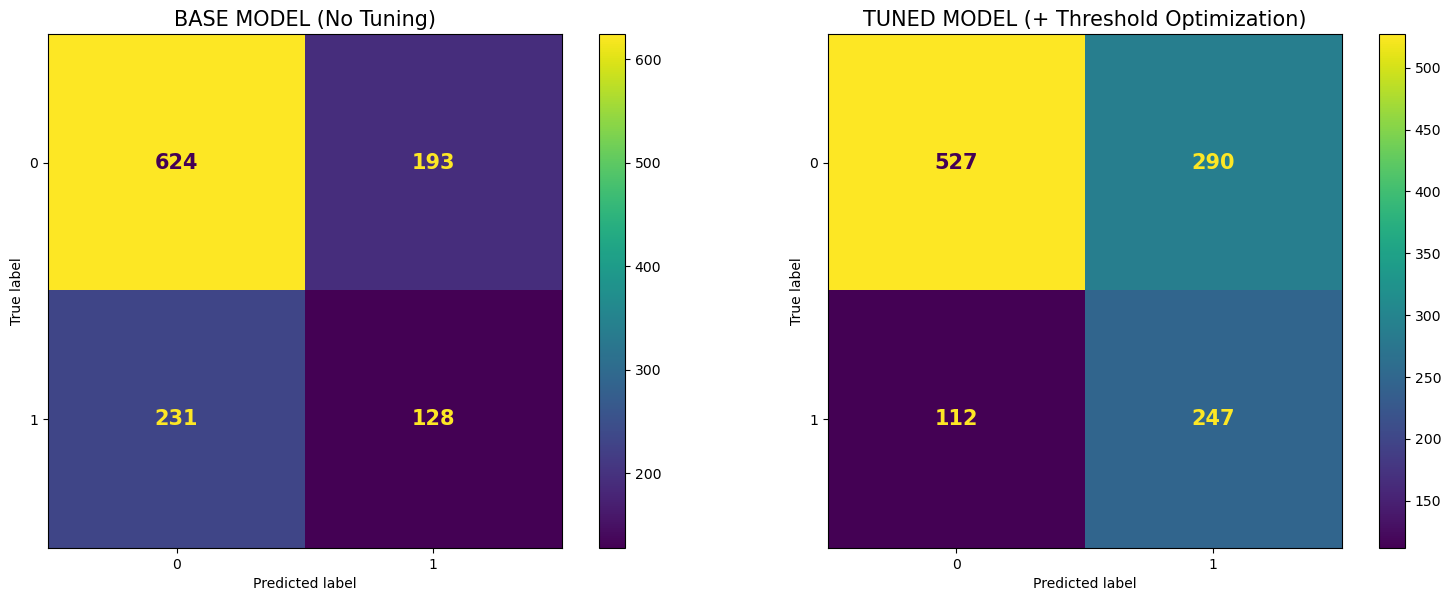

In [102]:
# Visualize confusion matrices
figure, axes = plt.subplots(ncols=2, figsize=(16, 6))

text_format = {'size': 15, 'weight': 'bold'}

ConfusionMatrixDisplay(conf_matrix_base).plot(ax=axes[0], text_kw=text_format)
axes[0].set_title("BASE MODEL (No Tuning)", fontsize=15)

ConfusionMatrixDisplay(conf_matrix_tuned).plot(ax=axes[1], text_kw=text_format)
axes[1].set_title("TUNED MODEL (+ Threshold Optimization)", fontsize=15)

plt.tight_layout()
plt.show()

In [131]:
# Compare business impact
print("=" * 50)
print("BASE MODEL DECISION TREE (No Tuning)")
print("=" * 50)
print(summarize_loss(conf_matrix_base, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

print("\n" + "=" * 50)
print("TUNED MODEL")
print("=" * 50)
print(summarize_loss(conf_matrix_tuned, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

BASE MODEL DECISION TREE (No Tuning)

    ---Impact Summary---

        Total Samples: 1176
        Total False Positive Cost: $-31,845.00
        Total False Negative Cost: $-577,500.00
        Total True Positive Benefit: $318,080.00
        Total Benefit: $-291,265.00

    ---------------
    

TUNED MODEL

    ---Impact Summary---

        Total Samples: 1176
        Total False Positive Cost: $-47,850.00
        Total False Negative Cost: $-280,000.00
        Total True Positive Benefit: $613,795.00
        Total Benefit: $285,945.00

    ---------------
    


In [104]:
# Benchmark: No model (predict all will not claim)
print("=" * 50)
print("NO MODEL: Predict all sellers will Churn")
print("=" * 50)
y_no_model = np.zeros(y_test.shape[0])
conf_matrix_no_model = confusion_matrix(y_test, y_no_model)
print(summarize_loss(conf_matrix_no_model, fp_cost=fp_cost, fn_cost=fn_cost, tp_benefit=tp_benefit))

NO MODEL: Predict all sellers will Churn

    ---Impact Summary---

        Total Samples: 1176
        Total False Positive Cost: $0.00
        Total False Negative Cost: $-897,500.00
        Total True Positive Benefit: $0.00
        Total Benefit: $-897,500.00

    ---------------
    


### **3.7 SHAP Analysis**

In [105]:
import joblib
import pickle
import shap

d:\Data\miniconda3\envs\base_copy\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [106]:
# Import datetime for systematic file naming
from datetime import datetime
import pickle

# Generate timestamp for file versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
print(f"Timestamp for this session: {timestamp}")

Timestamp for this session: 20260209_2020


In [107]:
pipe_tuned_dtree.fit(df[feature_cols],df['churned'])

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robust', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [108]:
# Save tuned model with timestamp
model_filename = f"pipe_tuned_dtree{timestamp}.pkl"
with open(model_filename, "wb") as f:
    pickle.dump(pipe_tuned_dtree, f)
print(f"Model saved as: {model_filename}")

Model saved as: pipe_tuned_dtree20260209_2020.pkl


In [109]:
pipe_tuned = joblib.load("pipe_tuned_dtree20260209_1722.pkl")
pipe_tuned

,steps,"[('preprocessing', ...), ('resampling', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('robust', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [110]:
pipe_tuned.steps

[('preprocessing',
  ColumnTransformer(remainder='passthrough',
                    transformers=[('robust', RobustScaler(),
                                   ['num_orders', 'total_revenue',
                                    'total_freight', 'avg_order_value',
                                    'days_active_in_quarter', 'num_categories',
                                    'prev_quarter_num_orders',
                                    'prev_quarter_total_revenue',
                                    'prev_quarter_total_freight',
                                    'orders_change_from_prev',
                                    'revenue_change_from_prev',
                                    'avg_num_orders_last_2q',
                                    'avg_total_revenue_last_2q',
                                    'lifetime_orders', 'lifetime_revenue',
                                    'tenure_quarters', 'quarters_since_first',
                                    'num_previous_act

In [111]:
dtree_model = pipe_tuned['dtree']
dtree_model

,criterion,'gini'
,splitter,'best'
,max_depth,2
,min_samples_split,30
,min_samples_leaf,11
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,'balanced'


In [112]:
preprocess_tuned = pipe_tuned["preprocessing"]
preprocess_tuned

,transformers,"[('robust', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,with_centering,True
,with_scaling,True
,quantile_range,"(25.0, ...)"


In [113]:
X_trans = preprocess_tuned.transform(df[feature_cols])
X_trans

,robust__num_orders,robust__total_revenue,robust__total_freight,robust__avg_order_value,robust__days_active_in_quarter,robust__num_categories,robust__prev_quarter_num_orders,robust__prev_quarter_total_revenue,robust__prev_quarter_total_freight,robust__orders_change_from_prev,robust__revenue_change_from_prev,robust__avg_num_orders_last_2q,robust__avg_total_revenue_last_2q,robust__lifetime_orders,robust__lifetime_revenue,robust__tenure_quarters,robust__quarters_since_first,robust__num_previous_active_quarters,robust__is_growing,robust__is_declining,robust__consecutive_declines,robust__quarter_of_year,robust__is_q4
0,-0.363636,0.262485,-0.325054,6.642789,-0.585714,0.0,-0.250,-0.157057,-0.186394,-0.2,1.005355,-0.380952,0.249733,-0.285714,-0.056335,-0.5,-0.5,-0.5,0.0,0.0,0.0,0.5,0.0
1,-0.272727,0.924169,-0.232970,6.642789,-0.500000,0.0,-0.125,0.785326,-0.065206,-0.2,1.005355,-0.333333,0.588335,-0.214286,0.477205,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,2.090909,1.652834,2.403207,0.042037,0.185714,0.0,-0.250,-0.157057,-0.186394,5.2,3.567899,2.190476,1.672695,0.678571,0.504210,-0.5,-0.5,-0.5,0.0,0.0,0.0,-0.5,0.0
3,5.363636,4.588699,8.892189,0.094191,0.671429,1.0,3.250,2.765489,3.525339,6.8,5.196885,3.904762,3.175059,2.964286,2.515173,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.545455,3.755695,9.409909,0.067353,0.700000,1.0,7.750,6.946805,12.065206,-2.2,-1.749496,5.190476,4.251152,4.928571,4.190295,0.5,0.5,0.5,-1.0,1.0,1.0,0.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6760,0.909091,1.302401,2.382661,0.492482,0.614286,1.0,0.375,0.972434,0.699337,1.6,1.460334,0.476190,0.849116,0.392857,0.682663,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
6761,1.363636,1.855997,4.216104,0.484852,0.400000,1.0,1.625,2.266394,3.498299,0.6,0.806140,1.190476,1.597332,1.107143,1.591887,0.5,0.5,0.5,0.0,0.0,0.0,-0.5,0.0
6762,0.818182,0.906721,2.678013,0.266324,0.400000,2.0,2.250,3.054837,5.911214,-1.6,-1.963795,1.142857,1.394852,1.607143,2.118392,1.0,1.0,1.0,-1.0,1.0,1.0,0.0,0.0
6763,-0.272727,-0.310112,-0.301178,-0.280411,-0.557143,1.0,-0.250,-0.157057,-0.186394,0.0,-0.049995,-0.285714,-0.336294,-0.250000,-0.287188,-0.5,-0.5,-0.5,0.0,0.0,0.0,1.0,1.0


In [114]:
X_transform_resampled, y_resampled = pipe_tuned["resampling"].fit_resample(X_trans, df['churned'])
X_transform_resampled

,robust__num_orders,robust__total_revenue,robust__total_freight,robust__avg_order_value,robust__days_active_in_quarter,robust__num_categories,robust__prev_quarter_num_orders,robust__prev_quarter_total_revenue,robust__prev_quarter_total_freight,robust__orders_change_from_prev,robust__revenue_change_from_prev,robust__avg_num_orders_last_2q,robust__avg_total_revenue_last_2q,robust__lifetime_orders,robust__lifetime_revenue,robust__tenure_quarters,robust__quarters_since_first,robust__num_previous_active_quarters,robust__is_growing,robust__is_declining,robust__consecutive_declines,robust__quarter_of_year,robust__is_q4
0,-0.363636,0.262485,-0.325054,6.642789,-0.585714,0.0,-0.250000,-0.157057,-0.186394,-0.200000,1.005355,-0.380952,0.249733,-0.285714,-0.056335,-0.500000,-0.500000,-0.500000,0.0,0.0,0.0,0.500000,0.0
1,-0.272727,0.924169,-0.232970,6.642789,-0.500000,0.0,-0.125000,0.785326,-0.065206,-0.200000,1.005355,-0.333333,0.588335,-0.214286,0.477205,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.000000,1.0
2,2.090909,1.652834,2.403207,0.042037,0.185714,0.0,-0.250000,-0.157057,-0.186394,5.200000,3.567899,2.190476,1.672695,0.678571,0.504210,-0.500000,-0.500000,-0.500000,0.0,0.0,0.0,-0.500000,0.0
3,5.363636,4.588699,8.892189,0.094191,0.671429,1.0,3.250000,2.765489,3.525339,6.800000,5.196885,3.904762,3.175059,2.964286,2.515173,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
4,4.545455,3.755695,9.409909,0.067353,0.700000,1.0,7.750000,6.946805,12.065206,-2.200000,-1.749496,5.190476,4.251152,4.928571,4.190295,0.500000,0.500000,0.500000,-1.0,1.0,1.0,0.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10209,-0.103738,-0.314168,-0.242090,-0.526256,-0.175286,0.0,0.107361,-0.059543,0.138508,-0.200000,-0.183664,-0.156296,-0.348921,-0.081508,-0.261219,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0
10210,-0.363636,-0.364735,-0.377051,-0.393492,-0.585714,0.0,-0.250000,-0.157057,-0.186394,-0.200000,-0.150671,-0.380952,-0.392199,-0.285714,-0.309210,-0.500000,-0.500000,-0.500000,0.0,0.0,0.0,-0.500000,0.0
10211,-0.032854,-0.324746,-0.081785,-0.603479,-0.585714,0.0,0.204825,0.308048,0.145933,-0.200000,-0.678864,-0.082038,-0.222257,0.236214,-0.051096,1.180699,1.180699,1.180699,0.0,0.0,0.0,-0.500000,0.0
10212,-0.363636,-0.371028,-0.348143,-0.464088,-0.585714,0.0,-0.250000,-0.157057,-0.186394,-0.200000,-0.162270,-0.380952,-0.398640,-0.285714,-0.311747,-0.500000,-0.500000,-0.500000,0.0,0.0,0.0,-0.500000,0.0


In [115]:
feature_names = X_transform_resampled.columns
feature_names

Index(['robust__num_orders', 'robust__total_revenue', 'robust__total_freight',
       'robust__avg_order_value', 'robust__days_active_in_quarter',
       'robust__num_categories', 'robust__prev_quarter_num_orders',
       'robust__prev_quarter_total_revenue',
       'robust__prev_quarter_total_freight', 'robust__orders_change_from_prev',
       'robust__revenue_change_from_prev', 'robust__avg_num_orders_last_2q',
       'robust__avg_total_revenue_last_2q', 'robust__lifetime_orders',
       'robust__lifetime_revenue', 'robust__tenure_quarters',
       'robust__quarters_since_first', 'robust__num_previous_active_quarters',
       'robust__is_growing', 'robust__is_declining',
       'robust__consecutive_declines', 'robust__quarter_of_year',
       'robust__is_q4'],
      dtype='object')

In [116]:
#Define Explainer
#untuk tree based (xgbosst, random forest, bagging, dsb) pakai TreeExplainer
#kalau linear/ logistic pakai LinearExplainer
explainer_shap = shap.TreeExplainer(
    model = dtree_model)

#Hitung shap value untuk tiap data
shap_values = explainer_shap(X_transform_resampled)

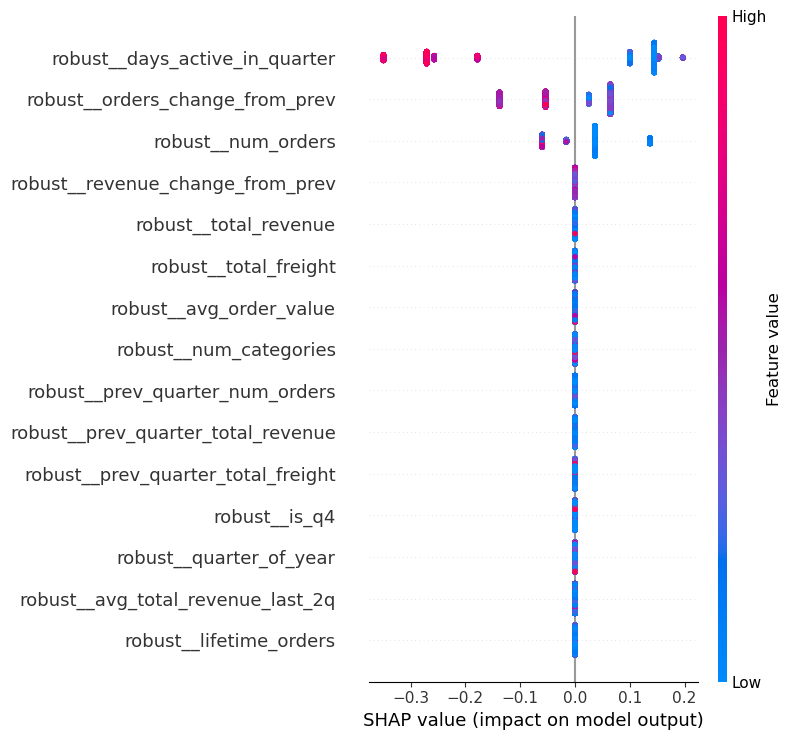

<Figure size 640x480 with 0 Axes>

In [117]:
# For classification - use values for one class
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values.values[:,:,1], X_transform_resampled, max_display=15)  # [:,:,1] for class 1
plt.tight_layout()
plt.show()

In [118]:
from sklearn.tree import plot_tree

label_names = y_train.astype("str")

fig, ax = plt.subplots(layout="constrained")
fig.set_size_inches(150, 100)

plot_tree(dtree_model, 
            feature_names=feature_names,
            class_names=label_names,
            filled=False,
            rounded=True,
            ax=ax)

[Text(0.5, 0.8333333333333334, 'robust__days_active_in_quarter <= 0.057\ngini = 0.5\nsamples = 10214\nvalue = [5107, 5107]\nclass = 0'),
 Text(0.25, 0.5, 'robust__orders_change_from_prev <= -0.0\ngini = 0.444\nsamples = 6536\nvalue = [2179, 4357]\nclass = 1'),
 Text(0.375, 0.6666666666666667, 'True  '),
 Text(0.125, 0.16666666666666666, 'gini = 0.38\nsamples = 4451\nvalue = [1134, 3317]\nclass = 1'),
 Text(0.375, 0.16666666666666666, 'gini = 0.5\nsamples = 2085\nvalue = [1045, 1040]\nclass = 0'),
 Text(0.75, 0.5, 'robust__num_orders <= 0.179\ngini = 0.325\nsamples = 3678\nvalue = [2928, 750]\nclass = 0'),
 Text(0.625, 0.6666666666666667, '  False'),
 Text(0.625, 0.16666666666666666, 'gini = 0.482\nsamples = 1118\nvalue = [665, 453]\nclass = 0'),
 Text(0.875, 0.16666666666666666, 'gini = 0.205\nsamples = 2560\nvalue = [2263, 297]\nclass = 0')]

### **3.8. Lime Analysis**

In [119]:
from lime.lime_tabular import LimeTabularExplainer

In [120]:
sample_X_transform = X_trans.iloc[0]
sample_X_transform

robust__num_orders                     -0.363636
robust__total_revenue                   0.262485
robust__total_freight                  -0.325054
robust__avg_order_value                 6.642789
robust__days_active_in_quarter         -0.585714
robust__num_categories                  0.000000
robust__prev_quarter_num_orders        -0.250000
robust__prev_quarter_total_revenue     -0.157057
robust__prev_quarter_total_freight     -0.186394
robust__orders_change_from_prev        -0.200000
robust__revenue_change_from_prev        1.005355
robust__avg_num_orders_last_2q         -0.380952
robust__avg_total_revenue_last_2q       0.249733
robust__lifetime_orders                -0.285714
robust__lifetime_revenue               -0.056335
robust__tenure_quarters                -0.500000
robust__quarters_since_first           -0.500000
robust__num_previous_active_quarters   -0.500000
robust__is_growing                      0.000000
robust__is_declining                    0.000000
robust__consecutive_

d:\Data\miniconda3\envs\base_copy\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


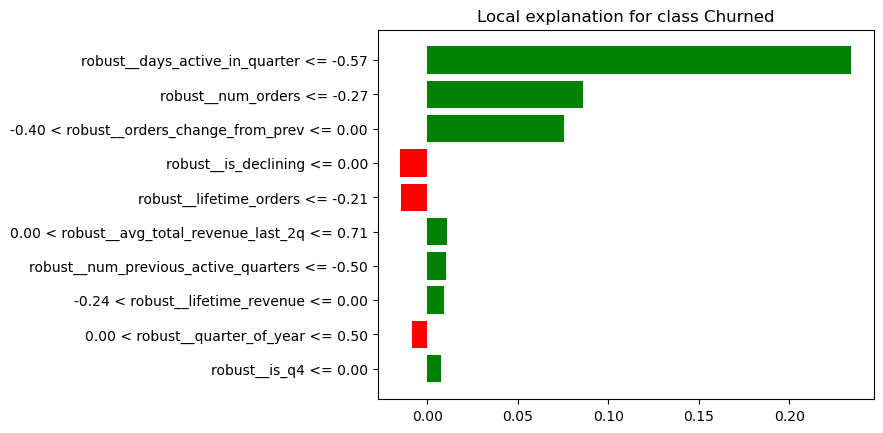

In [121]:
#Create LIME explainer
explainer_lime = LimeTabularExplainer(
    training_data = X_trans.values, #lime tabular butuh input array ga bisa dataframe
    feature_names = feature_names, # karena harus ada array, perlu ini biar ada nama kolomnya
    mode="classification", #untuk model klasifikasi
    random_state = 0, # biar gak keubah pas di run ulang
    class_names = ["Not Churned", "Churned"] #optional
)

explanation = explainer_lime.explain_instance(
    data_row = sample_X_transform.values, #sample yang mau dijelaskan (harus_array)
    predict_fn = dtree_model.predict_proba, #model untuk prediksi
    num_features = 10 #top 10 features
)

#Display explanation plot
fig = explanation.as_pyplot_figure()
plt.show()


### **3.9. Summary and Recommendation**

##### **3.9.1 Model Summary**

- Strengths :
    -	The tuned model generates a net benefit of **$285,945** compared to **-$897,500** for no intervention, representing a total improvement of **$1,183,445**.
    -	Achieved $613,795 in true positive benefits by correctly identifying churning sellers, enabling proactive retention strategies.
    -	Decreased false negative costs from $897,500 (no model) to $280,000 (tuned model), representing a **69% reduction** in missed churn cases.
    -	Decision tree model provides clear, explainable predictions that can be understood by business stakeholders and acted upon effectively.
    -	Model prioritizes catching churners (high recall) which aligns with business objectives where missing a churner is more costly than false alarms

- Weakness :
    - The tuned model has higher false positive costs ($47,850 vs $31,845 in base model), indicating some sellers are incorrectly flagged as churning.
    - Seller churn is likely an imbalanced problem where churned sellers are the minority class
    



##### **3.9.2 SHAP Summary**

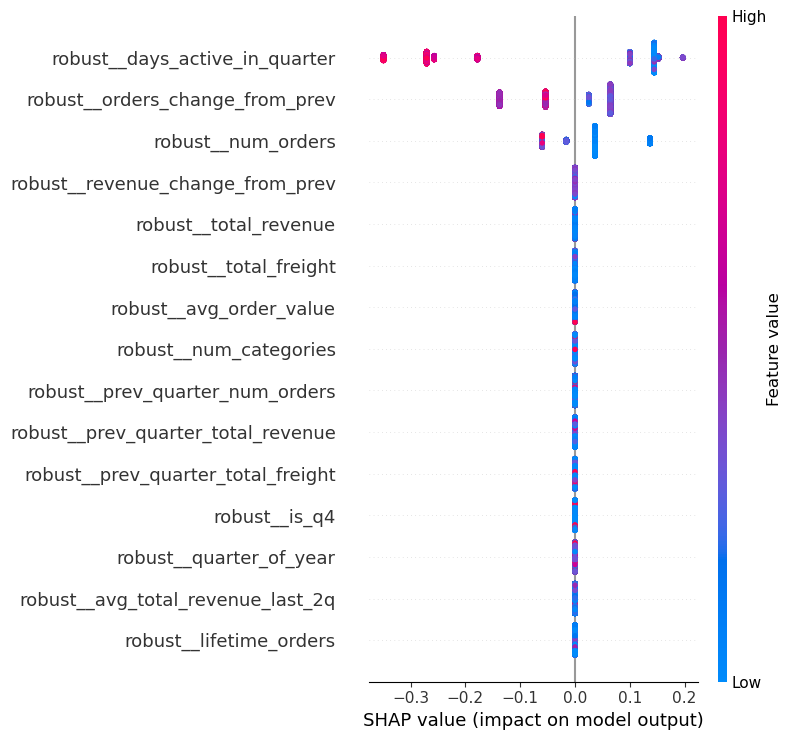

- days active in quarter id aligned with seller churn or not. The longer a seller is active in a quarter, the less likely they will churn
- change of order nominal is also aligned with seller churn. Mostly(not all), if theres a significant order nominal change from a quarter to another one, usually the seller will be less likely to churn
- the number of orders a seller have is also aligned with the seller churn. Low sales number means the seller will be more likely to churn.

#### **3.9.3 Recommendation**

- Add features related to customer satisfaction (review scores complaint frequency) and repeat purchase rates.
- Do feature importance to minimize overfitting chances


### **3.10. Streamlit and GitHub Preparation**

In [122]:
import dill

In [123]:
##Save the lime explainer for deployment
with open ("lime_explainer.dill", 'wb') as file:
    dill.dump(explainer_lime, file)

print("LIME EXPLAINER SAVED SUCCESFULLY")

LIME EXPLAINER SAVED SUCCESFULLY


In [124]:
#module version checking
import sklearn
import imblearn
import numpy as np
import pandas as pd
import streamlit as st
import joblib
import dill
import matplotlib


In [125]:
modules = [sklearn, imblearn, np, pd, st, joblib, dill, matplotlib]
for module in modules:
    versi = module.__version__
    print(f"Versi modul {module} = {versi} ")

Versi modul <module 'sklearn' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\sklearn\\__init__.py'> = 1.7.1 
Versi modul <module 'imblearn' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\imblearn\\__init__.py'> = 0.14.0 
Versi modul <module 'numpy' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\numpy\\__init__.py'> = 2.3.3 
Versi modul <module 'pandas' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\pandas\\__init__.py'> = 2.3.2 
Versi modul <module 'streamlit' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\streamlit\\__init__.py'> = 1.49.1 
Versi modul <module 'joblib' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\joblib\\__init__.py'> = 1.5.2 
Versi modul <module 'dill' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\dill\\__init__.py'> = 0.4.0 
Versi modul <module 'matplotlib' from 'd:\\Data\\miniconda3\\envs\\base_copy\\Lib\\site-packages\\matplotlib\\__init_

In [126]:
pip show lime

Name: lime
Version: 0.2.0.1
Summary: Local Interpretable Model-Agnostic Explanations for machine learning classifiers
Home-page: http://github.com/marcotcr/lime
Author: Marco Tulio Ribeiro
Author-email: marcotcr@gmail.com
License: BSD
Location: d:\Data\miniconda3\envs\base_copy\Lib\site-packages
Requires: matplotlib, numpy, scikit-image, scikit-learn, scipy, tqdm
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [127]:
to_requirements = '''scikit-learn==1.7.1
imbalanced-learn==0.14.0 
numpy==2.3.3 
pandas==2.3.2 
streamlit==1.49.1 
matplotlib==3.10.6 
joblib==1.5.2 
dill==0.4.0
lime==0.2.0.1
'''

In [128]:
with open ("requirements.txt", "w") as file:
    file.write(to_requirements) #ga pakai binary karena mau ngesave text

print("TO REQUIREMENT SAVED SUCCESFULLY")

TO REQUIREMENT SAVED SUCCESFULLY


In [129]:
pd.set_option('display.max_colwidth', None)


cat_feature_cols = X_train.select_dtypes(exclude='number').columns

unique_values_df = pd.DataFrame({
    'column': cat_feature_cols,
    'unique_values': [X_train[col].unique().tolist() for col in cat_feature_cols]
})


#unique_values_df.to_csv("kolom_kategori_unique_values.csv", index = False)
unique_values_df

,column,unique_values


In [130]:
features = df[feature_cols]

features.to_csv("numerical_data.csv", index = False)
features

,num_orders,total_revenue,total_freight,avg_order_value,days_active_in_quarter,num_categories,prev_quarter_num_orders,prev_quarter_total_revenue,prev_quarter_total_freight,orders_change_from_prev,revenue_change_from_prev,avg_num_orders_last_2q,avg_total_revenue_last_2q,lifetime_orders,lifetime_revenue,tenure_quarters,quarters_since_first,num_previous_active_quarters,is_growing,is_declining,consecutive_declines,quarter_of_year,is_q4
0,1.0,895.00,21.02,895.000000,0,1,0.0,0.00,0.00,1.0,895.00,1.0,895.000,1.0,895.00,1,0,0,1,0,0,3,0
1,2.0,1790.00,42.04,895.000000,6,1,1.0,895.00,21.02,1.0,895.00,1.5,1342.500,3.0,2685.00,2,1,1,1,0,0,4,1
2,28.0,2775.60,643.80,99.128571,54,1,0.0,0.00,0.00,28.0,2775.60,28.0,2775.600,28.0,2775.60,1,0,0,1,0,0,1,0
3,64.0,6746.68,2125.04,105.416875,88,2,28.0,2775.60,643.80,36.0,3971.08,46.0,4761.140,92.0,9522.28,2,1,1,1,0,0,2,0
4,55.0,5619.95,2243.22,102.180909,90,2,64.0,6746.68,2125.04,-9.0,-1126.73,59.5,6183.315,147.0,15142.23,3,2,2,0,1,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6760,15.0,2301.60,639.11,153.440000,84,2,5.0,1072.70,153.63,10.0,1228.90,10.0,1687.150,20.0,3374.30,2,1,1,1,0,0,4,1
6761,20.0,3050.40,1057.63,152.520000,69,2,15.0,2301.60,639.11,5.0,748.80,17.5,2676.000,40.0,6424.70,3,2,2,1,0,0,1,0
6762,14.0,1766.40,706.53,126.171429,69,3,20.0,3050.40,1057.63,-6.0,-1284.00,17.0,2408.400,54.0,8191.10,4,3,3,0,1,1,2,0
6763,2.0,120.50,26.47,60.250000,2,2,0.0,0.00,0.00,2.0,120.50,2.0,120.500,2.0,120.50,1,0,0,1,0,0,4,1
